In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb

In [2]:
cellType = "RAS20mM2DG" #RAS PC3 DITNC1 SC P 0.75mM2DG 2mM2DG 5mM2DG 10mM2DG
numCores = 10
numBestFitIters = 200
numMonteCarloIters = 300
numMonteCarloIters_downsample = 200
vhvds = {"vhvd_nadh_ldh":1.7,"vhvd_nadh_mas":1.08,"vhvd_nadh_g3ps":1.5,"vhvd_dhap_g3ps":1.0,"vhvd_nadh_dhap_g3ps":1.5,"vhvd_gap_gapdh":1.89}
#vhvds = {"vhvd_nadh_ldh":1.0,"vhvd_nadh_mas":1.0,"vhvd_nadh_g3ps":1.0,"vhvd_dhap_g3ps":1.0,"vhvd_nadh_dhap_g3ps":1.0}

In [3]:
concentration = pd.read_csv("../data/concentrations.csv",index_col=0)
excret = pd.read_csv("../data/excretion_flux.csv",index_col=0)
lacEx = excret.at[cellType,"lactate_excretion_fmol_cell_min"]
gluUp = excret.at[cellType,"glucose_uptake_fmol_cell_min"]
concs = {met:val for met,val in zip(concentration.columns.values,concentration.loc[cellType,:].values)}
print(concs)
print(lacEx,gluUp)


{'NAD(H)': 0.764658647, 'Malate': 0.585431755, 'G3P': 0.079442897, 'Lactate': 9.496490251}
3.793129604 4.691456889


[ 0  0  0  2  2  2  2  5  5  5 10 10 10 20 20 20]


,L_malate,UL_malate,L_g3p_M+1,L_g3p_M+2,UL_g3p,L_lac,UL_lac,L_gap,UL_gap,L_nadh,UL_nadh
0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,0.010511,0.989489,0.010344,0.000000,0.989656,0.004060,0.995940,0.018373,0.981627,0.025569,0.974431
4,0.007659,0.992341,0.002567,0.000000,0.997433,0.003256,0.996744,0.018961,0.981039,0.110156,0.889844
5,0.011868,0.988132,0.002988,0.000000,0.997012,0.004536,0.995464,0.021358,0.978642,0.033594,0.966406
6,0.013320,0.986680,0.003697,0.000000,0.996303,0.004773,0.995227,0.025698,0.974302,0.029759,0.970241
7,0.019669,0.980331,0.077263,0.000000,0.922737,0.010715,0.989285,0.050901,0.949099,0.095688,0.904312
8,0.027749,0.972251,0.069978,0.000000,0.930022,0.013663,0.986337,0.057743,0.942257,0.071034,0.928966
9,0.026002,0.973998,0.000000,0.000000,1.000000,0.012228,0.987772,0.020341,0.979659,0.382713,0.617287


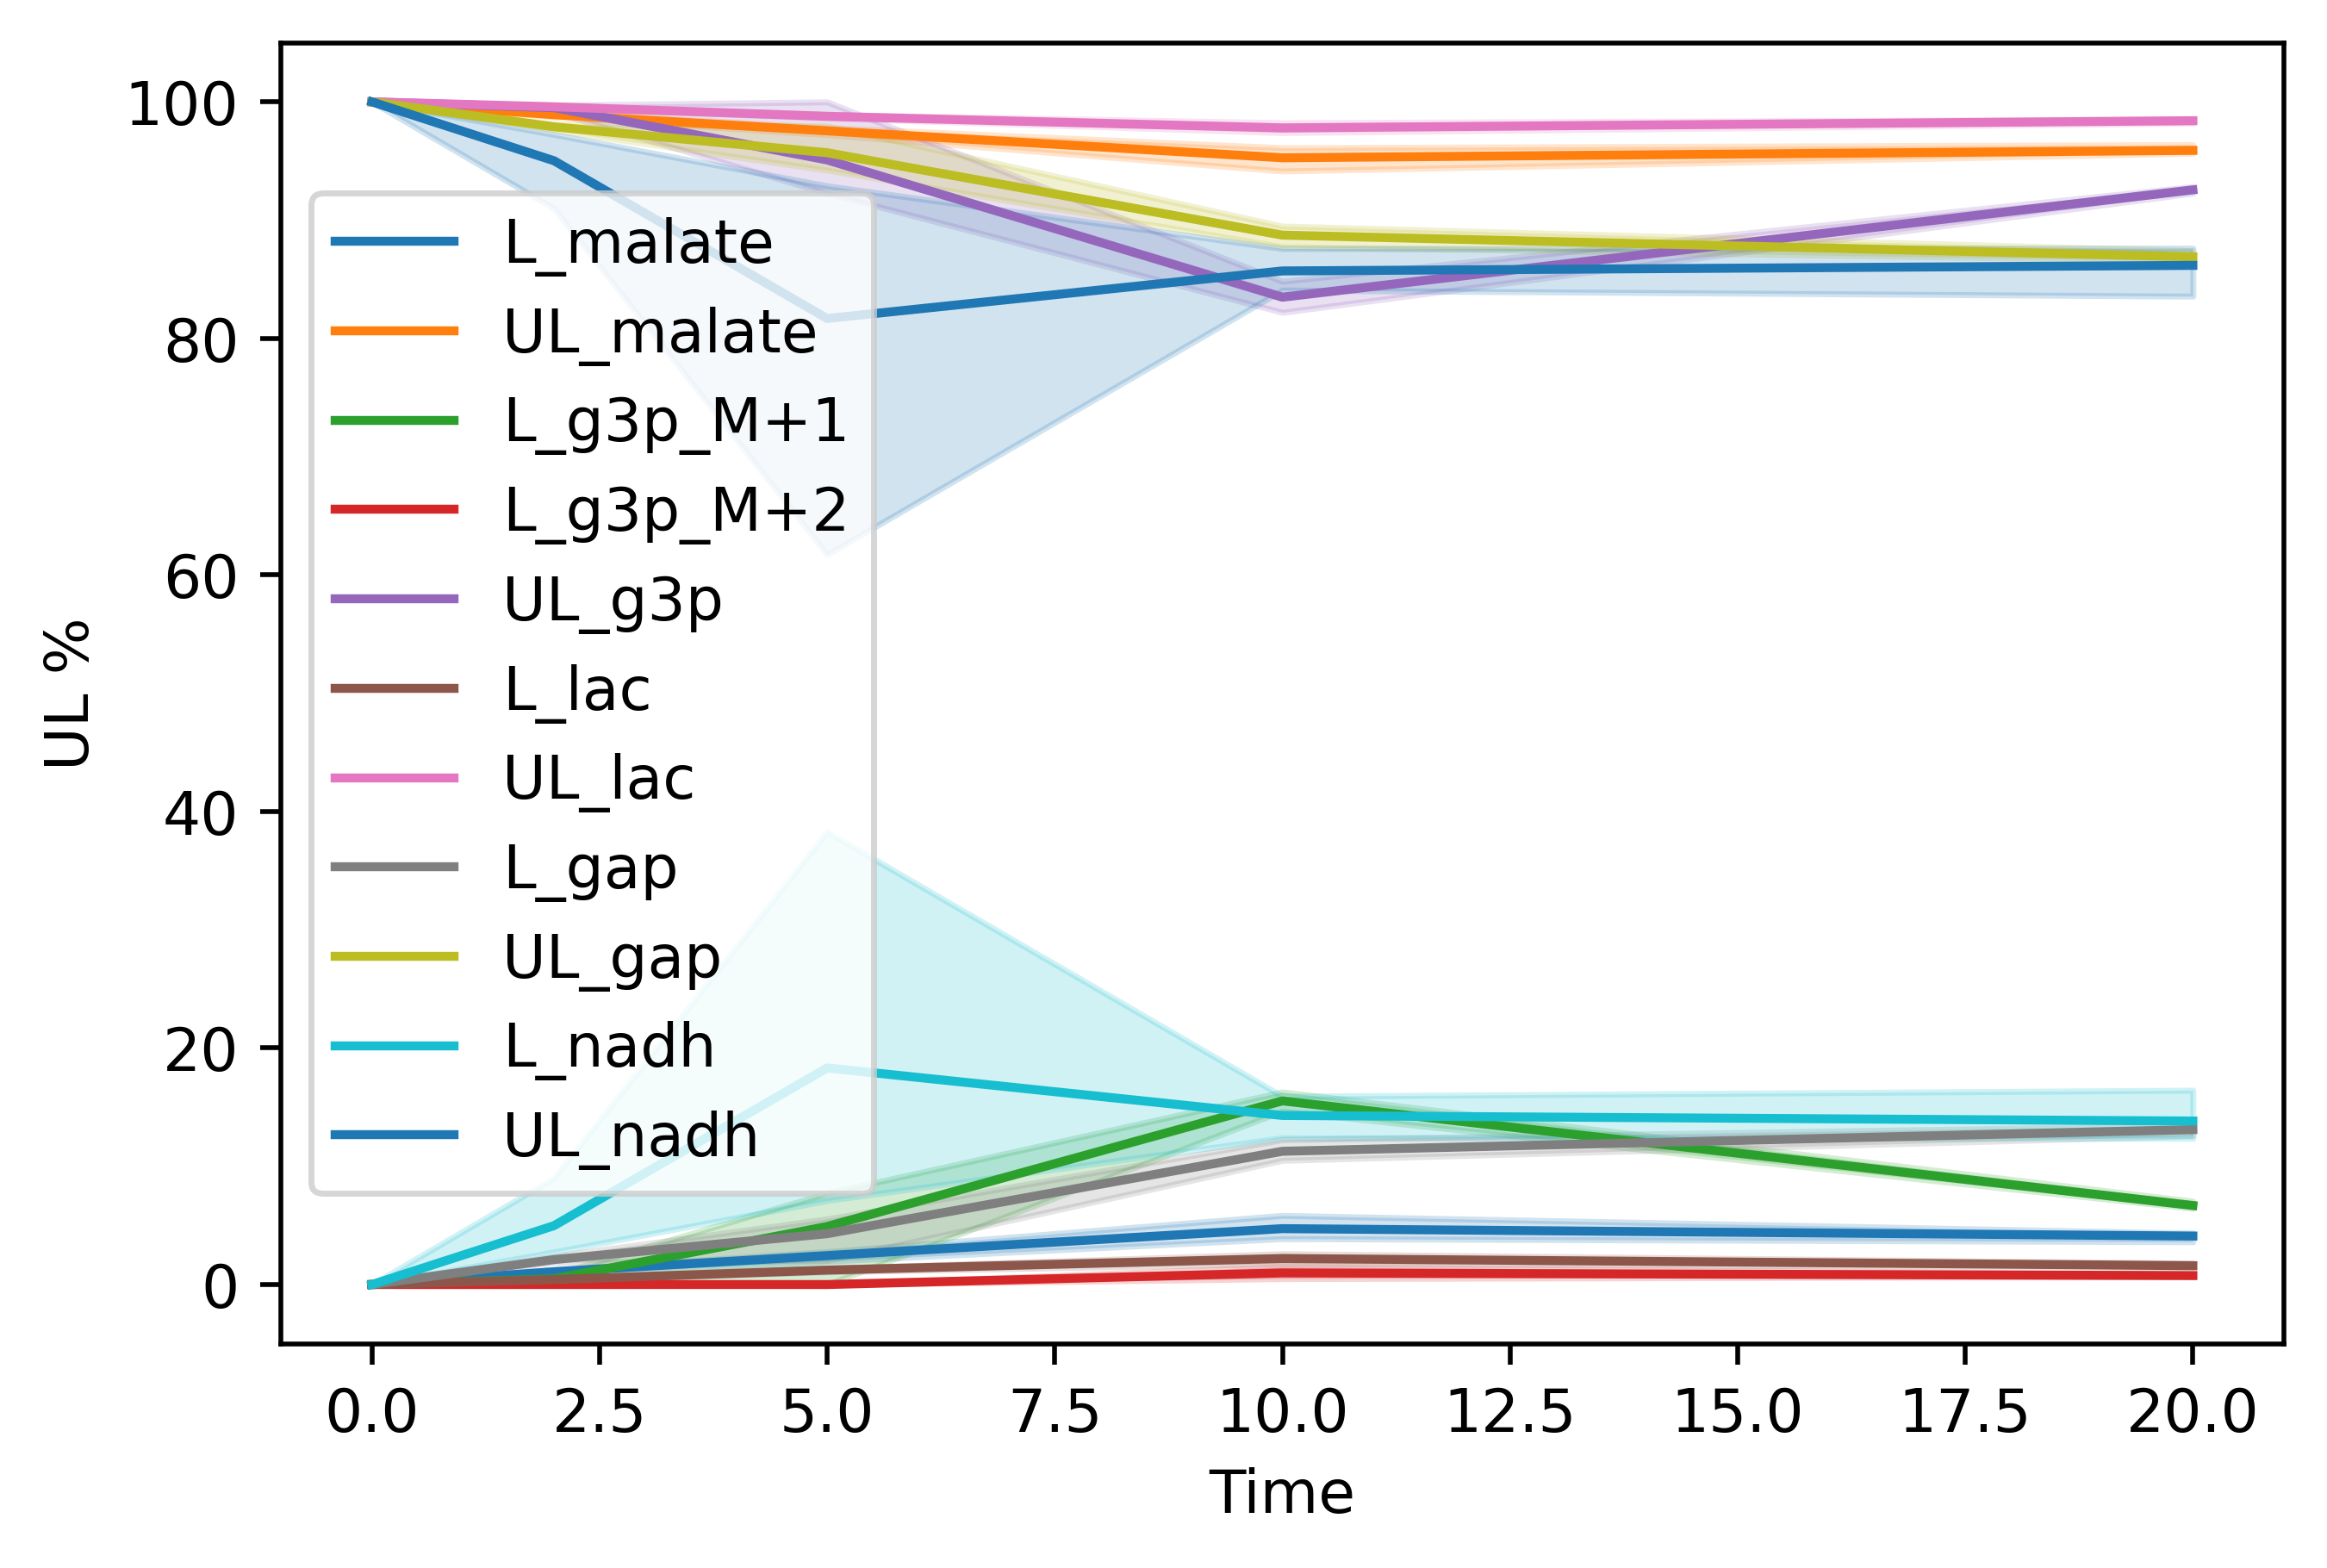

In [4]:
data = pd.read_csv("../data/" + cellType + "/" + cellType+".csv")
data = data.fillna(0)

lastT = np.max(data["Time"])
lastT = data[data["Time"] == lastT].index.values

filt = data.loc[lastT,:]
gap = filt["L_gap"].values.mean() / 100
nadh = filt["L_nadh"].values.mean() / 100
g3p = [filt["UL_g3p"].values.mean() / 100, filt["L_g3p_M+1"].values.mean() / 100, filt["L_g3p_M+2"].values.mean()/100]

#data = data[["Time","UL_malate","UL_g3p","UL_lac","UL_gap","UL_nadh"]]
for val in data.columns.values[1:]:
    sb.lineplot(data=data,x="Time",y=val,label=val)
plt.legend()

plt.ylabel("UL %")

t = data["Time"].values
data = data[data.columns.values[1:]]
data = data/100
conc = concs
print(t)
data

finding best fit |██████████████████████████████████████████████████| 100.0% 


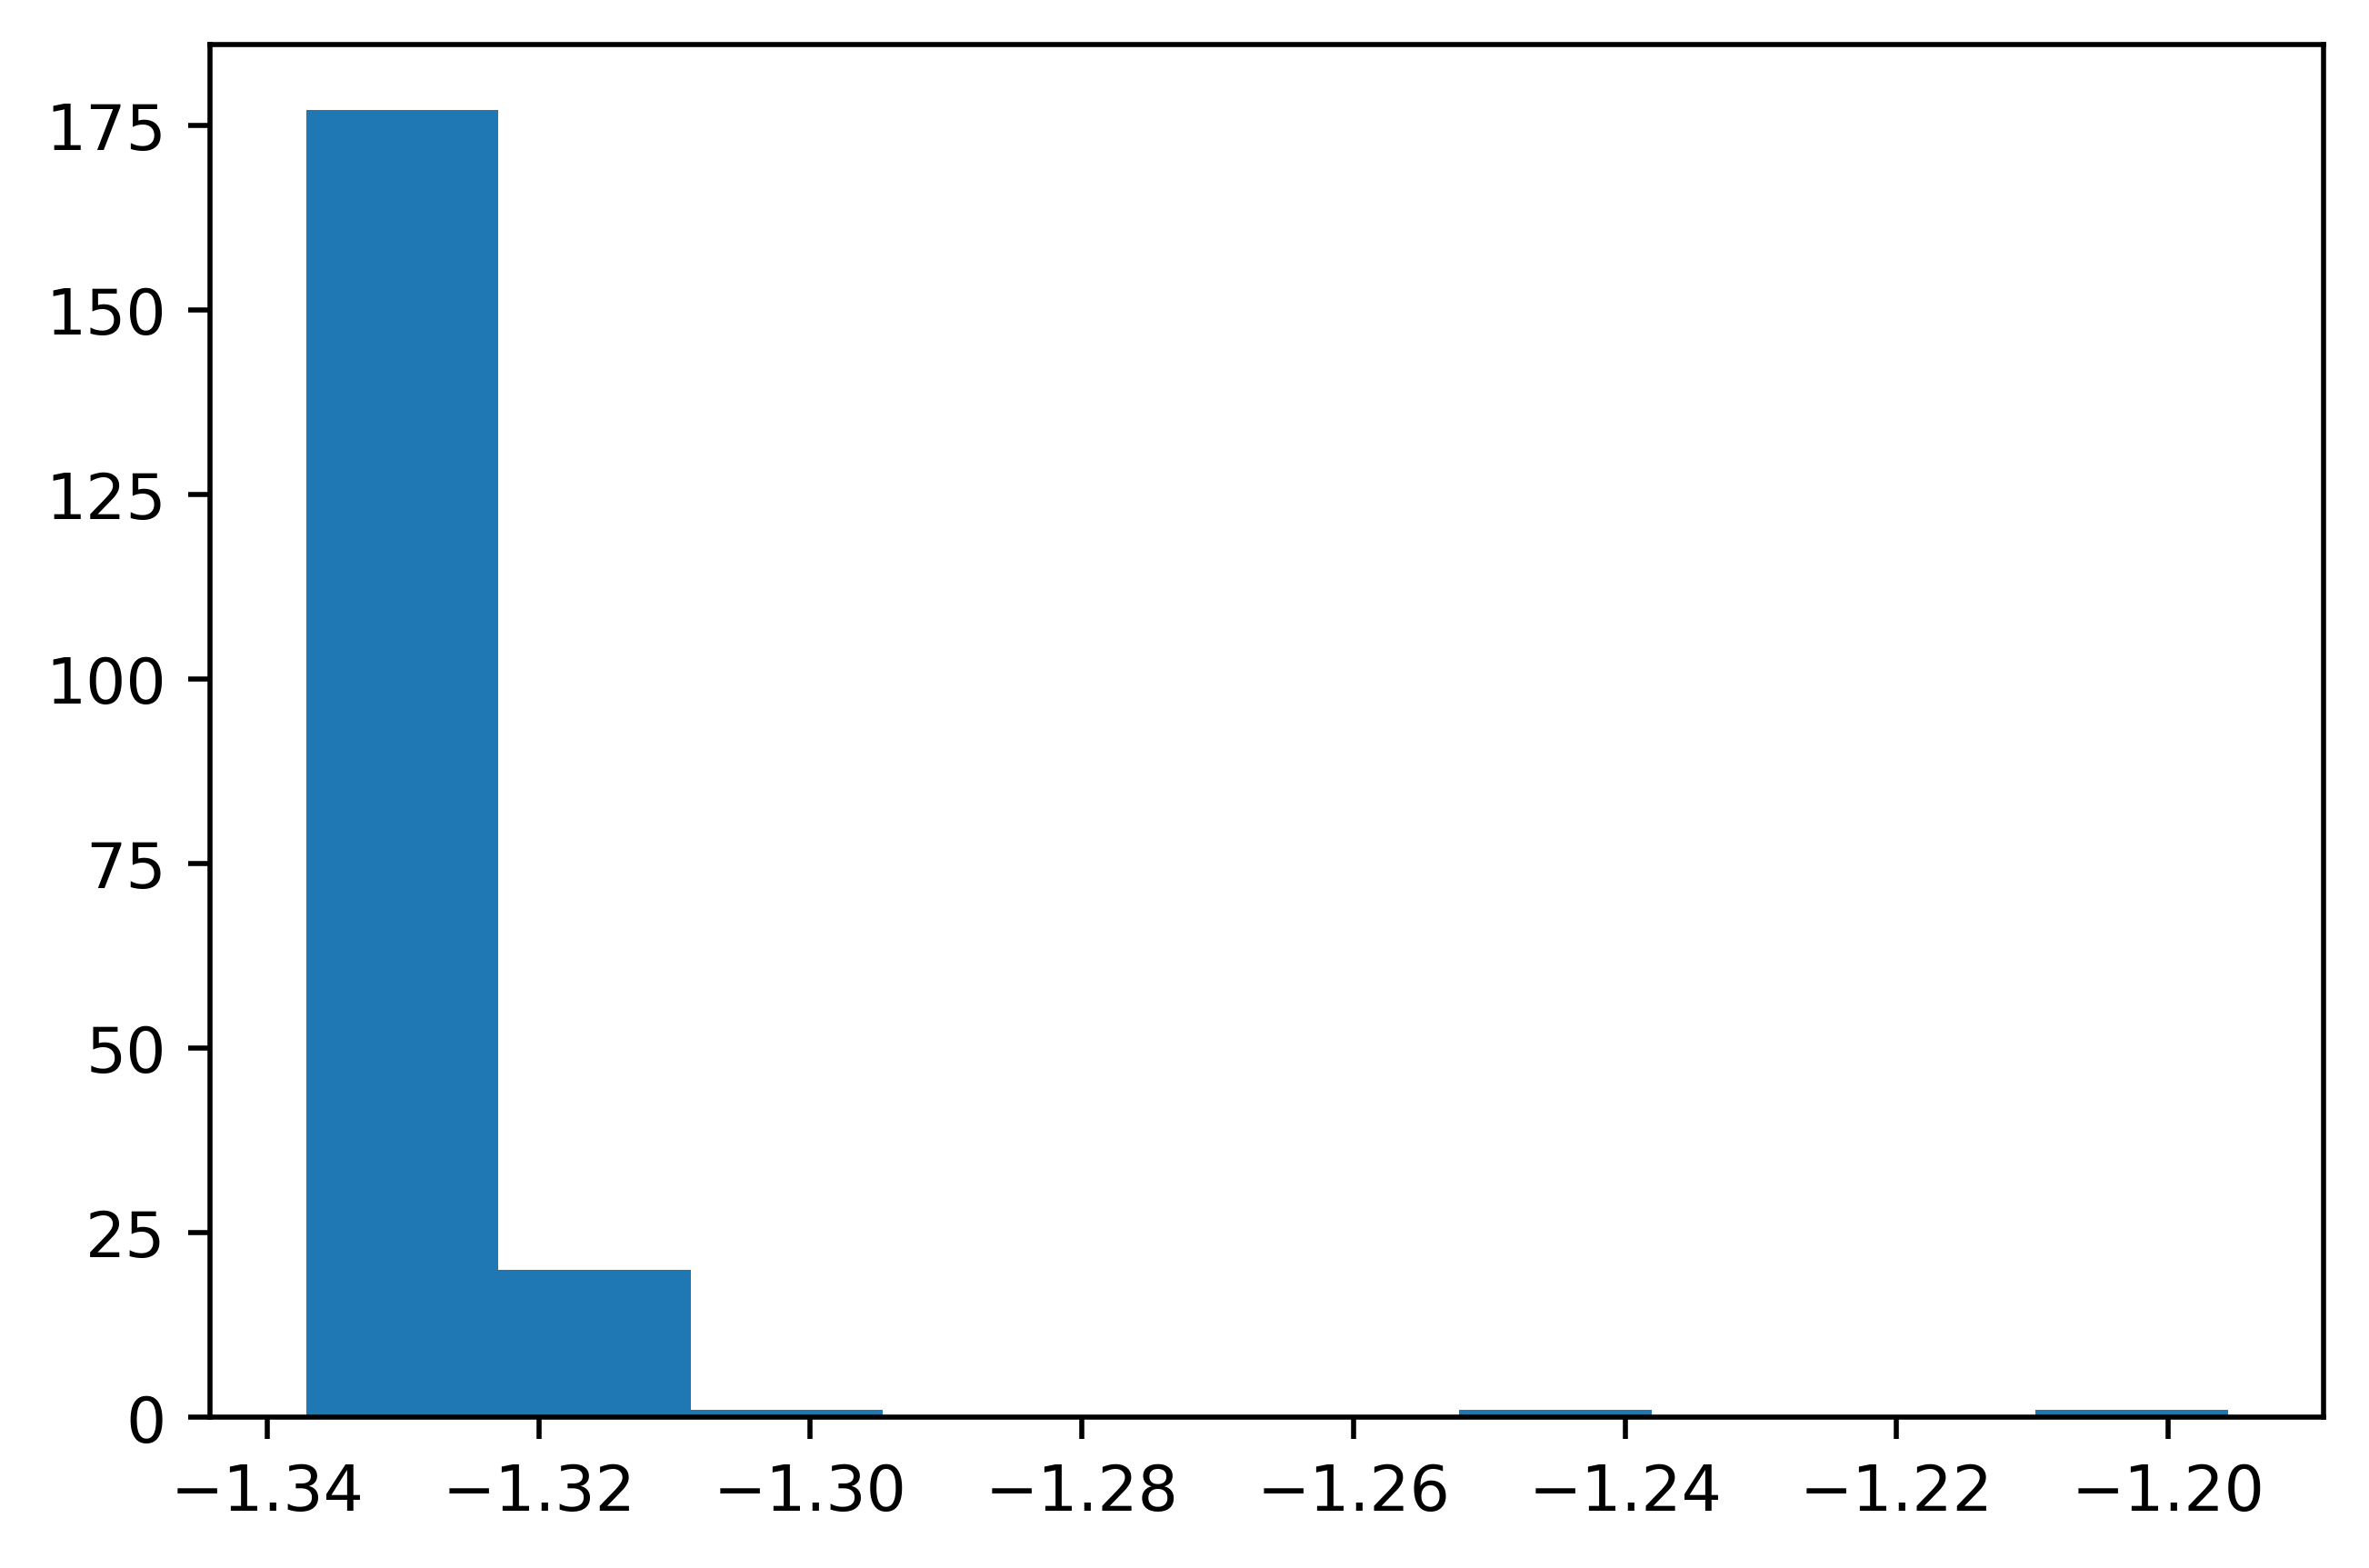

In [5]:
if __name__ == '__main__':
    rd.seed(1000)
    np.random.seed(1000)
    args = [[data,t,conc,lacEx,gluUp,vhvds,np.random.random(4)] for _ in range(numBestFitIters)]
    startingParams = startConcurrentTask(findFlux,args,numCores,"finding best fit",len(args))
    startingParams = [x for x in startingParams if type(x) != type(-1)]
    plt.hist([[np.log10(np.sum(x[-1])) for x in startingParams]])
    startingParams.sort(key=lambda x: np.sum(x[-1]))
    plt.show()


In [6]:
fluxes_inferred,C0s_inferred,df,conc,error = findFlux(data,t,conc,lacEx,gluUp,vhvds,startingParams[0][0])

../src\flux_finding_mp.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  weights = [np.min([1,1/np.std(data["UL_gap"].values[tMapper[t[x]]])]) for x in range(len(t))]
../src\flux_finding_mp.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  weights = np.array([[np.min([1,1/np.std(data[lab].values[tMapper[t[x]]])]) for x in range(len(t))] for lab in ["UL_lac","UL_g3p","UL_malate"]]).transpose()


ISS NADH labeling:  0.13594398011972242


../src\flux_finding_mp.py:200: RuntimeWarning: invalid value encountered in double_scalars
  nadh = lambda z:state[3]/concs["NADH"]
../src\flux_finding_mp.py:154: RuntimeWarning: invalid value encountered in double_scalars
  return unlabeled_flux + vh * gap(t) - (unlabeled_flux+ct * vh) * state / conc
../src\flux_finding_mp.py:213: RuntimeWarning: invalid value encountered in true_divide
  result[:,x] = sol[:,x]/concs[labels[x]]


In [7]:
print(startingParams[0][-1])
print(error)

[0.00059996 0.04366199 0.00175218 0.        ]
[0.00059996 0.0436504  0.0017452  0.        ]


In [8]:
fluxes_inferred

array([ 3.7931296 ,  2.00816813,  1.94428441, 13.05912488])

In [9]:
C0s_inferred

array([ 4.07344634,  1.899079  ,  2.07930685, -0.40688352])

In [10]:
conc

{'NAD(H)': 0.764658647,
 'Malate': 0.585431755,
 'G3P': 0.079442897,
 'Lactate': 9.496490251,
 'NADH': 3.870799428699695e-05}

In [11]:
if __name__ == '__main__':
    allFluxes = runMonteCarlo(data,t,conc,lacEx,gluUp,vhvds,fluxes_inferred,numMonteCarloIters,numCores)

resampling datasets |██████████████████████████████████████████████████| 100.0% 
running monte carlo |██████████████████████████████████████████████████| 100.0% 
300 successful iterations complete


In [26]:
pkl.dump([allFluxes,fluxes_inferred,C0s_inferred,error],open("../data/" + str(cellType) + "/" + cellType + ".pkl","wb"))

[allFluxes,fluxes_inferred,C0s_inferred,error] = pkl.load(open("../data/" + str(cellType) + "/" + cellType + ".pkl","rb"))

[interval,intervalParams,allFluxes] = removeBadSol(allFluxes,ci=95,cutoff=2*np.sum(error),target=numMonteCarloIters_downsample)

print(fluxes_inferred) #fluxes are in (ldh, g3ps, mas, and gapdh)
print(C0s_inferred)

[ 3.7931296   2.00816813  1.94428441 13.05912488]
[ 4.07344634  1.899079    2.07930685 -0.40688352]


In [27]:
df

,L_malate,UL_malate,L_g3p_M+1,L_g3p_M+2,UL_g3p,L_lac,UL_lac,L_gap,UL_gap,L_nadh,UL_nadh,L_g3p
0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-0.005493,1.005493,0.000000,1.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-0.005493,1.005493,0.000000,1.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-0.005493,1.005493,0.000000,1.000000,0.000000
3,0.005974,0.994026,0.010344,0.000000,0.987407,0.001751,0.998249,0.023158,0.976842,0.021045,0.978955,0.012593
4,0.005974,0.994026,0.002567,0.000000,0.987407,0.001751,0.998249,0.023158,0.976842,0.021045,0.978955,0.012593
5,0.005974,0.994026,0.002988,0.000000,0.987407,0.001751,0.998249,0.023158,0.976842,0.021045,0.978955,0.012593
6,0.005974,0.994026,0.003697,0.000000,0.987407,0.001751,0.998249,0.023158,0.976842,0.021045,0.978955,0.012593
7,0.015801,0.984199,0.077263,0.000000,0.968927,0.005644,0.994356,0.057174,0.942826,0.053428,0.946572,0.031073
8,0.015801,0.984199,0.069978,0.000000,0.968927,0.005644,0.994356,0.057174,0.942826,0.053428,0.946572,0.031073
9,0.015801,0.984199,0.000000,0.000000,0.968927,0.005644,0.994356,0.057174,0.942826,0.053428,0.946572,0.031073


In [28]:
data

,L_malate,UL_malate,L_g3p_M+1,L_g3p_M+2,UL_g3p,L_lac,UL_lac,L_gap,UL_gap,L_nadh,UL_nadh,t
0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0
1,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0
2,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0
3,0.010511,0.989489,0.010344,0.000000,0.989656,0.004060,0.995940,0.018373,0.981627,0.025569,0.974431,2
4,0.007659,0.992341,0.002567,0.000000,0.997433,0.003256,0.996744,0.018961,0.981039,0.110156,0.889844,2
5,0.011868,0.988132,0.002988,0.000000,0.997012,0.004536,0.995464,0.021358,0.978642,0.033594,0.966406,2
6,0.013320,0.986680,0.003697,0.000000,0.996303,0.004773,0.995227,0.025698,0.974302,0.029759,0.970241,2
7,0.019669,0.980331,0.077263,0.000000,0.922737,0.010715,0.989285,0.050901,0.949099,0.095688,0.904312,5
8,0.027749,0.972251,0.069978,0.000000,0.930022,0.013663,0.986337,0.057743,0.942257,0.071034,0.928966,5
9,0.026002,0.973998,0.000000,0.000000,1.000000,0.012228,0.987772,0.020341,0.979659,0.382713,0.617287,5


In [29]:
t_t = np.linspace(0,3*max(t),100)



In [30]:
outdict = {"MDH":{"bestFit":fluxes_inferred[2],"LB":interval[2][0],"UB":interval[2][1]},
           "GPD":{"bestFit":fluxes_inferred[1],"LB":interval[1][0],"UB":interval[1][1]},
           "LDH":{"bestFit":fluxes_inferred[0],"LB":interval[0][0],"UB":interval[0][1]},
          "SSE":{"bestFit":np.sum(error),"LB":None,"UB":None}}
outdict = pd.DataFrame.from_dict(outdict,orient="index")
outdict.to_csv("../data/" + cellType + "/" + cellType + "_fluxes.csv")
outdict

,bestFit,LB,UB
MDH,1.944284,1.404884,2.117019
GPD,2.008168,1.207583,2.665641
LDH,3.793130,3.793130,3.793130
SSE,0.045996,NaN,NaN


In [31]:
dhap_params = fitSource(t, data["UL_gap"])

firstT = np.min(t)
firstT = [x for x in range(len(t)) if abs(firstT-t[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate","UL_nadh"],[conc["Lactate"],conc["G3P"],conc["Malate"],conc["NADH"]])]
predictedL = integrateLabelingModel(t_t,fluxes_inferred,conc,dhap_params,C0s_inferred,vhvds,initialState)


[3.7931296039948004, 3.7931296039999998]
[1.207582686591759, 2.665640725004301]
[1.4048838600676046, 2.11701886577131]


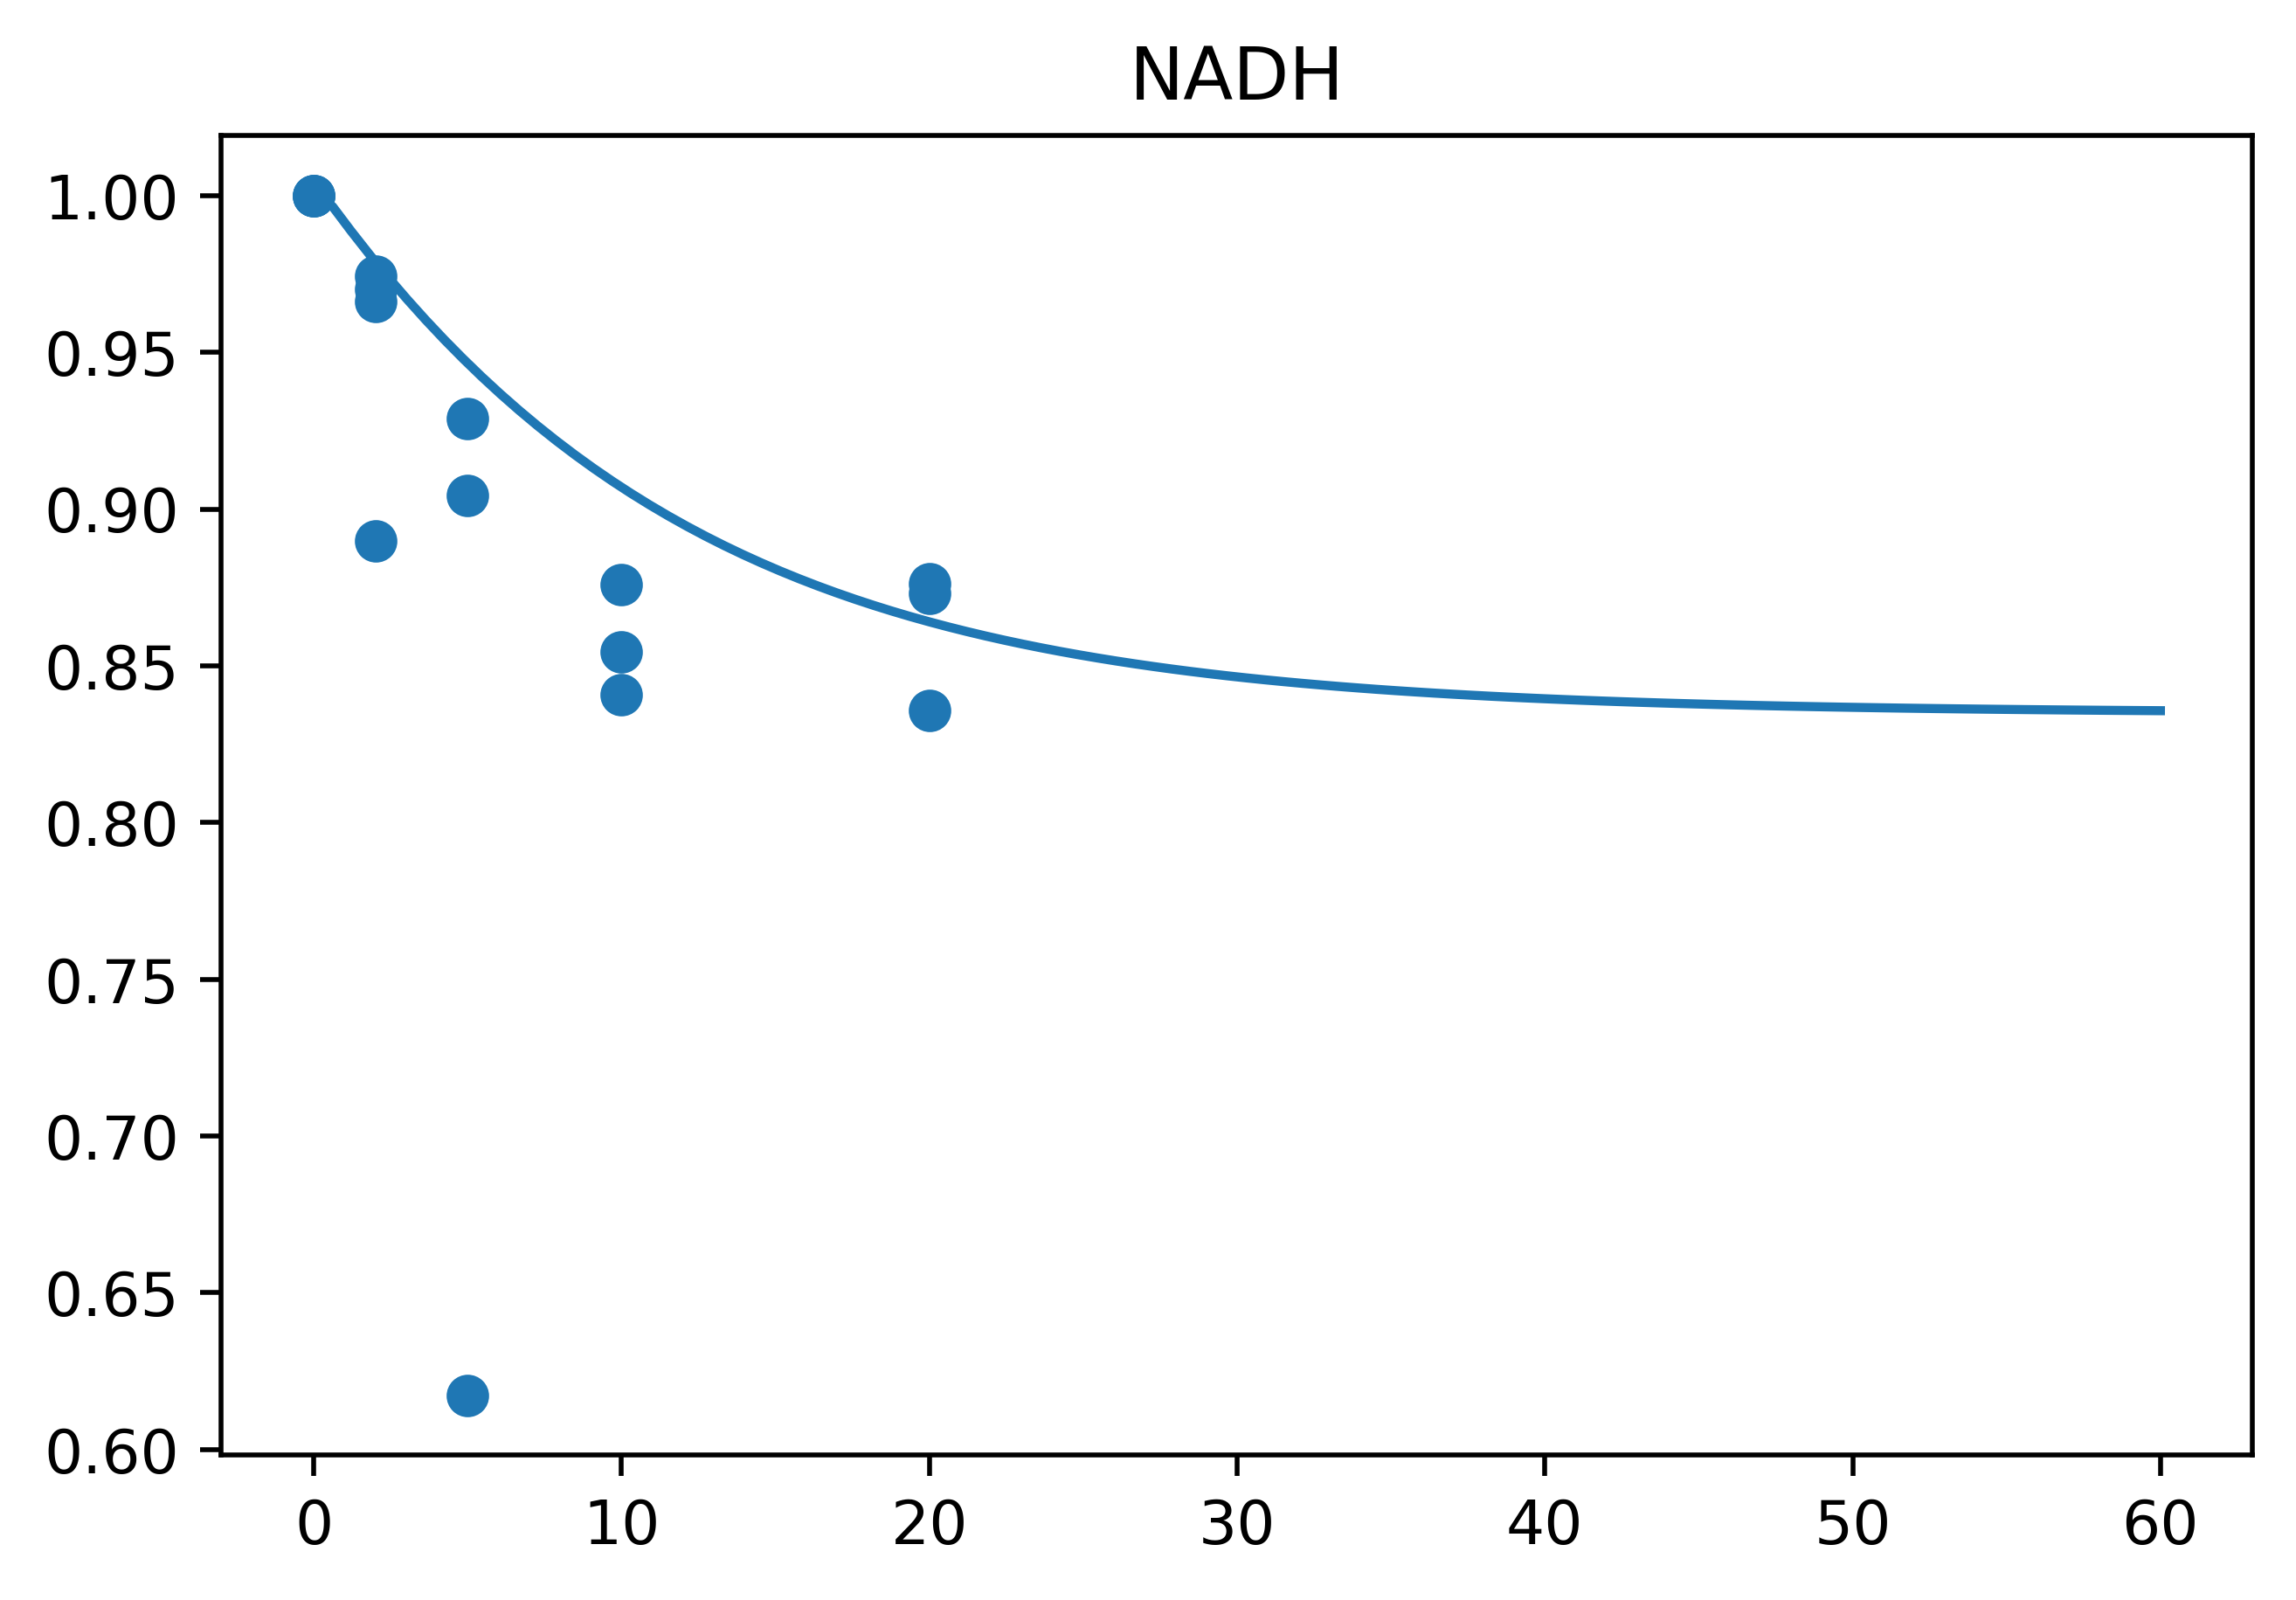

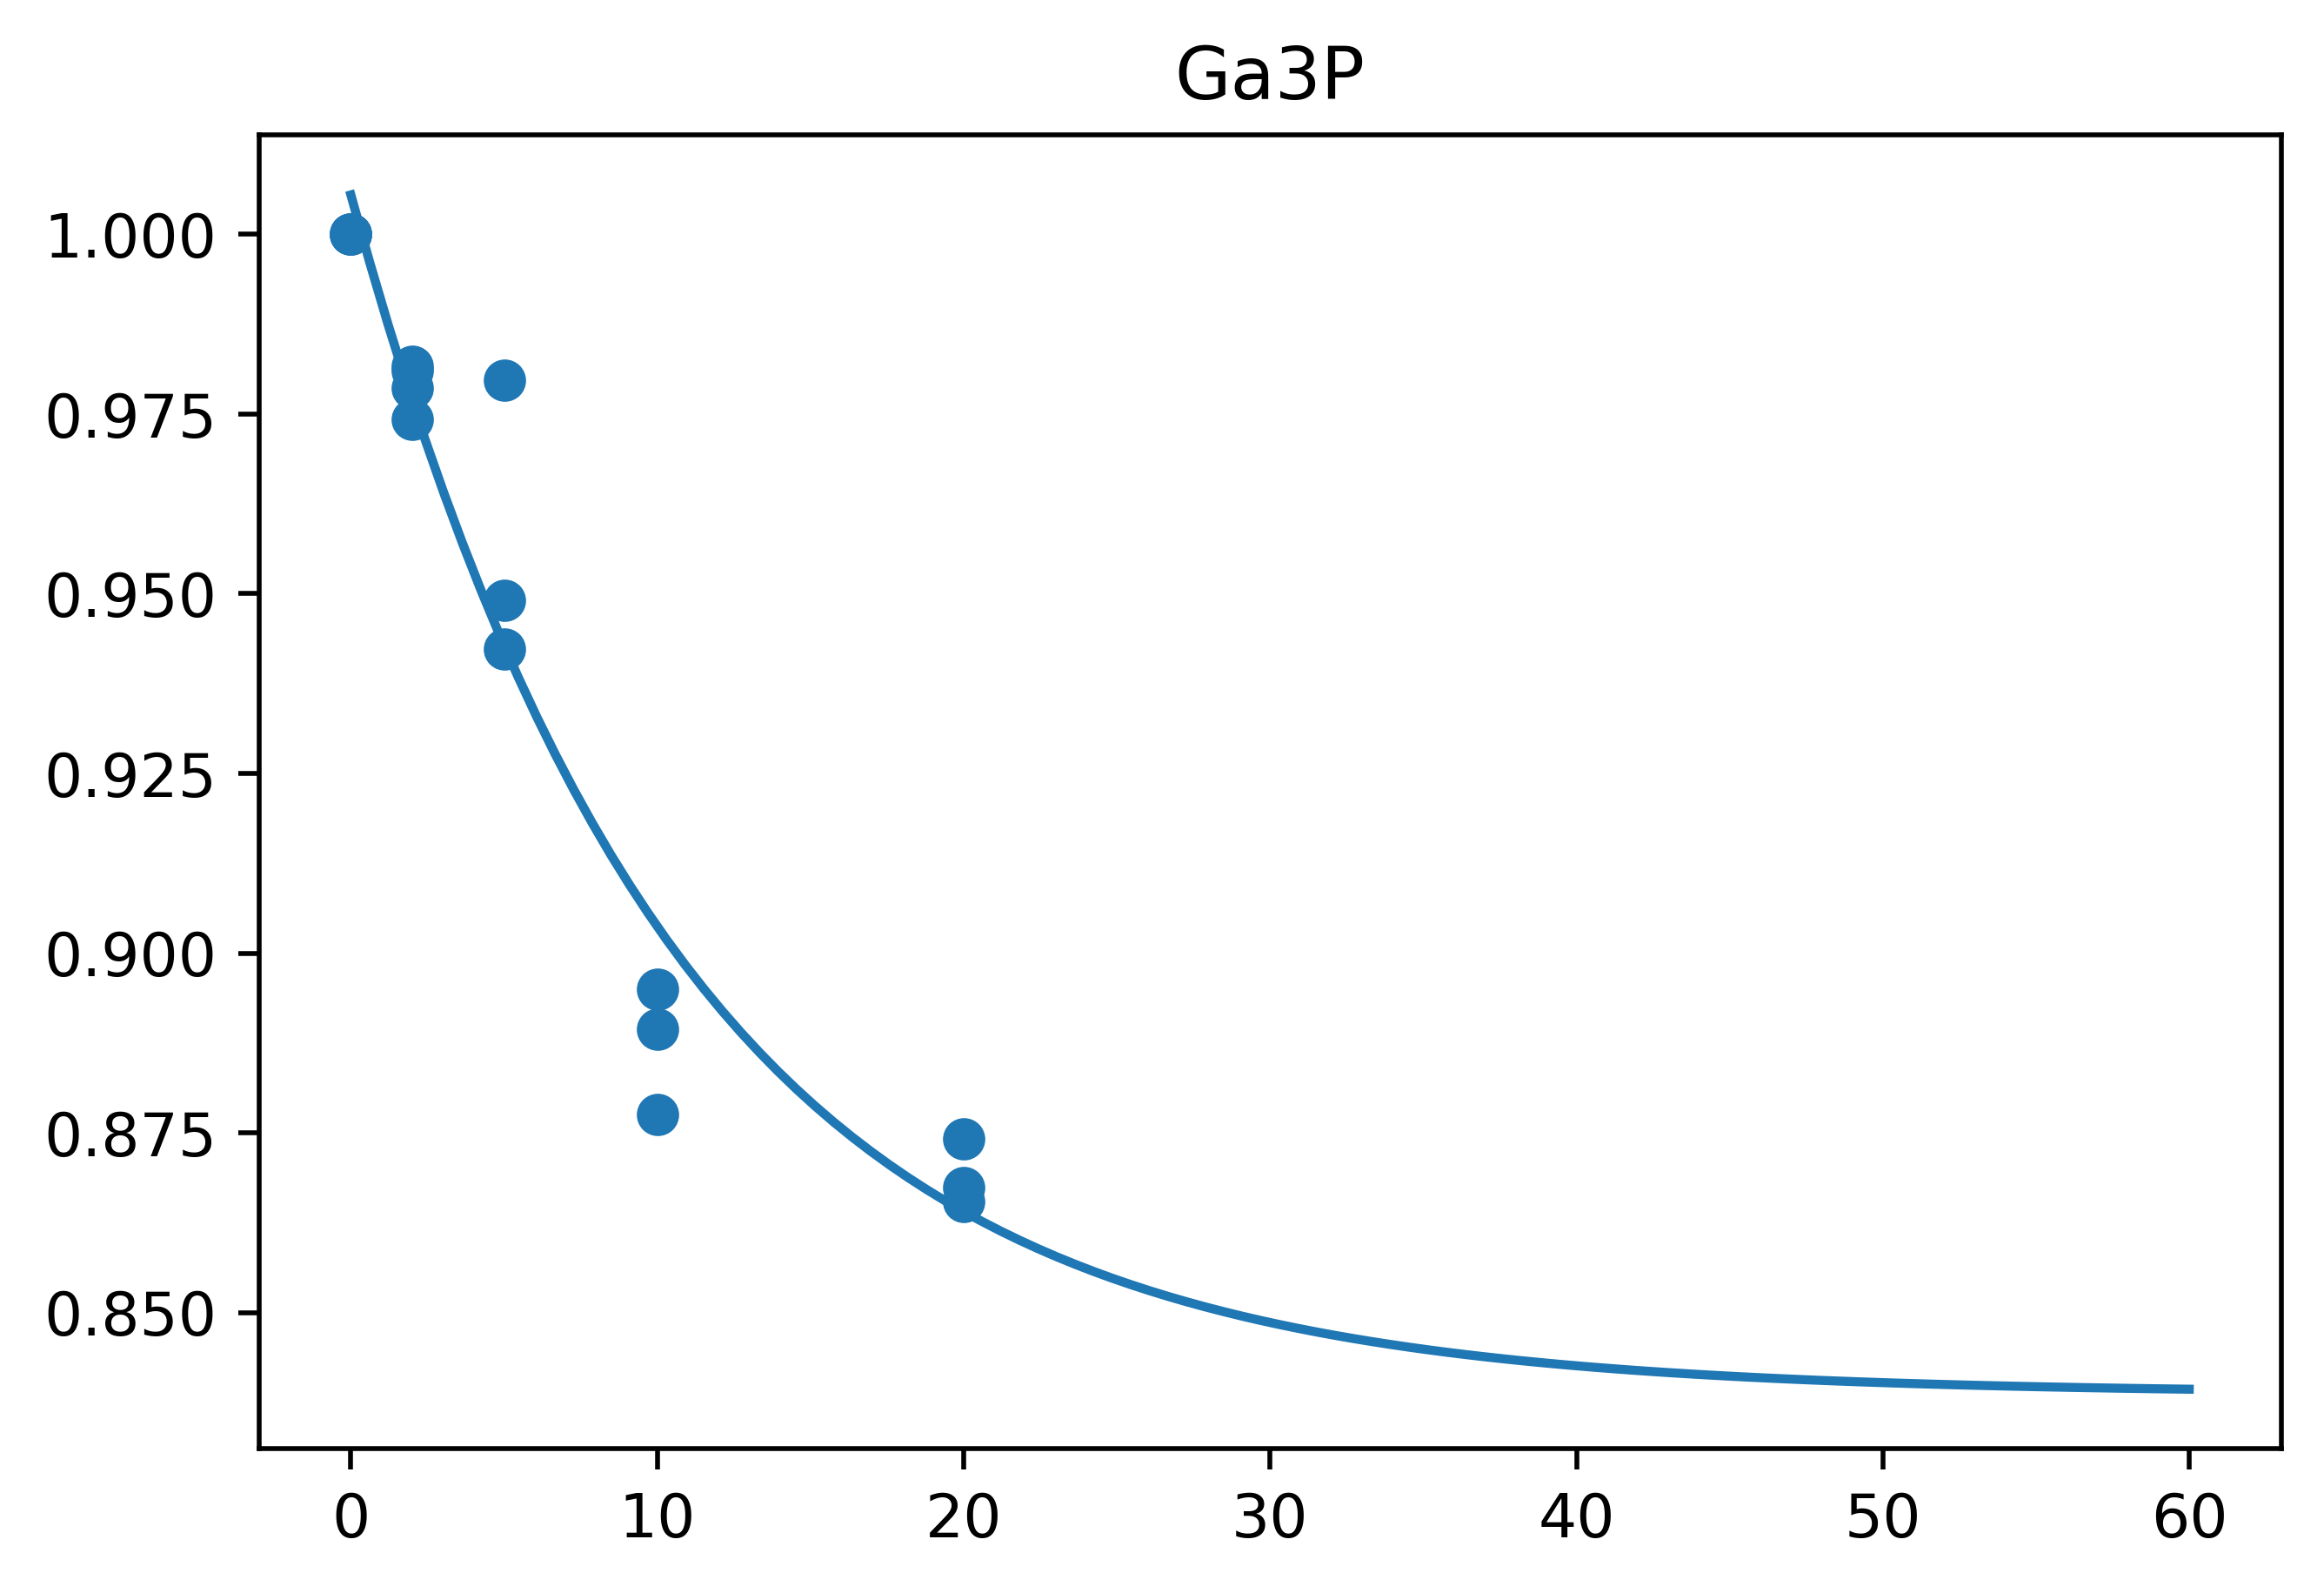

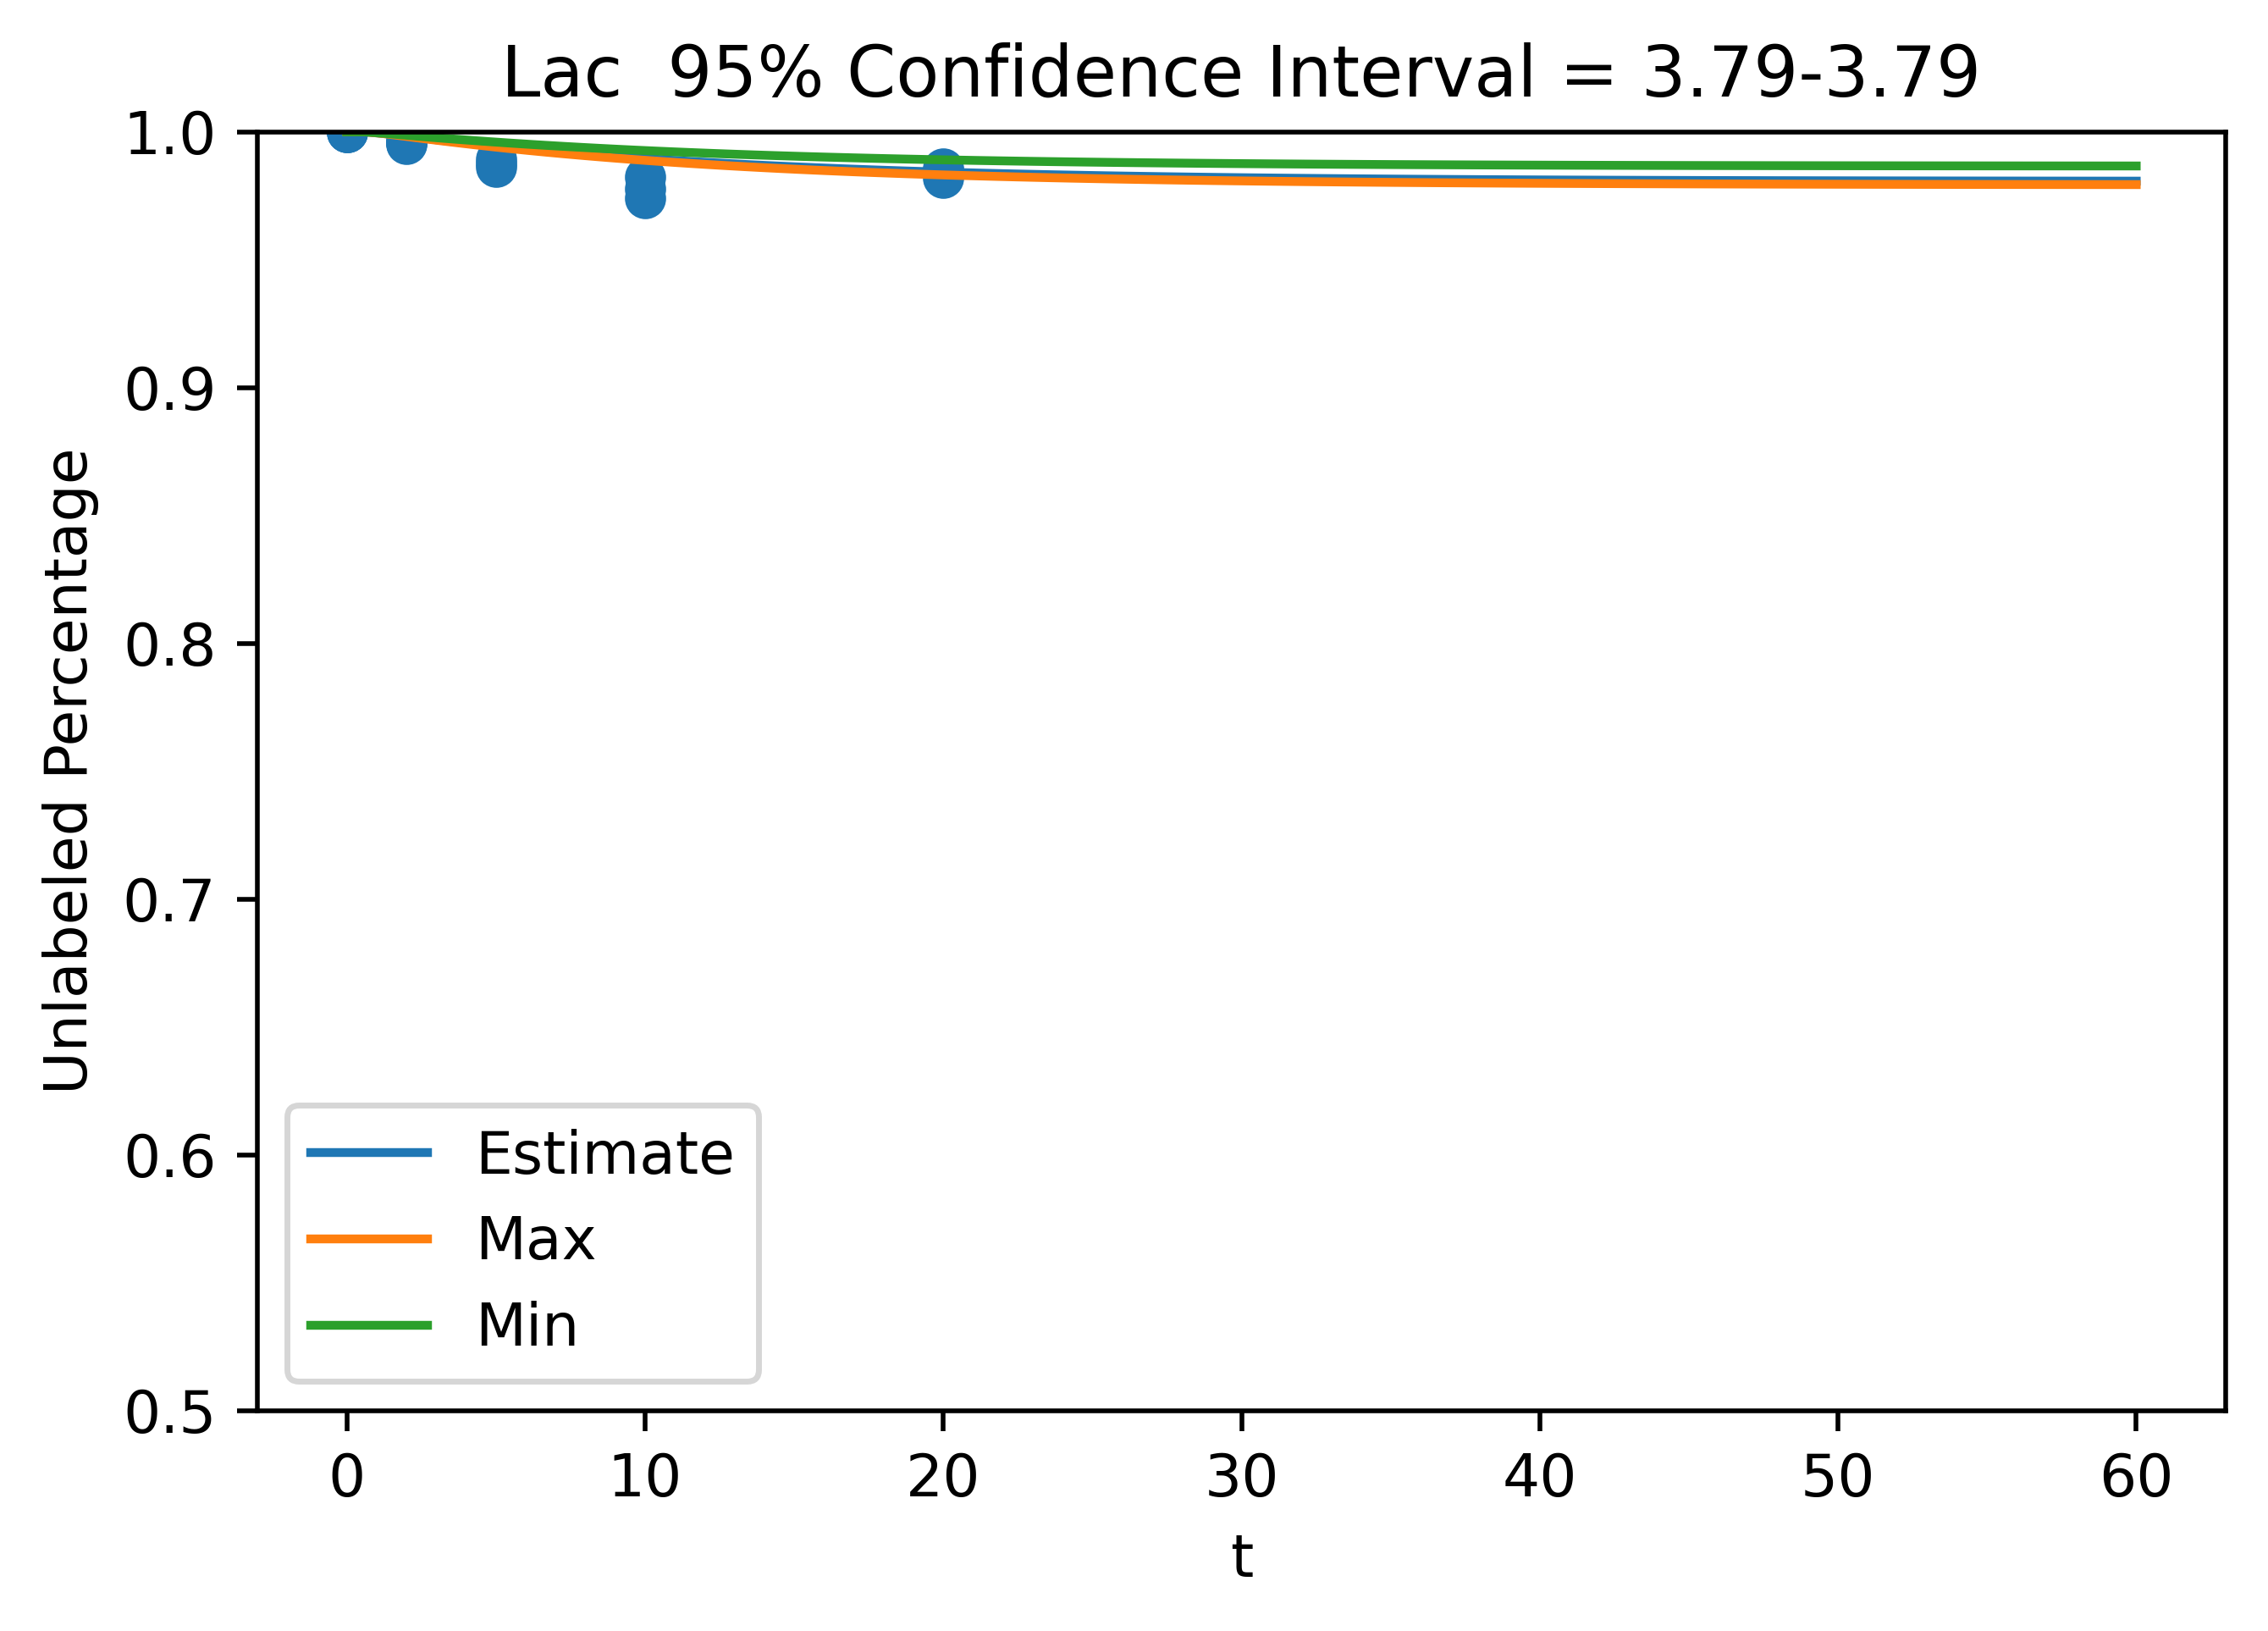

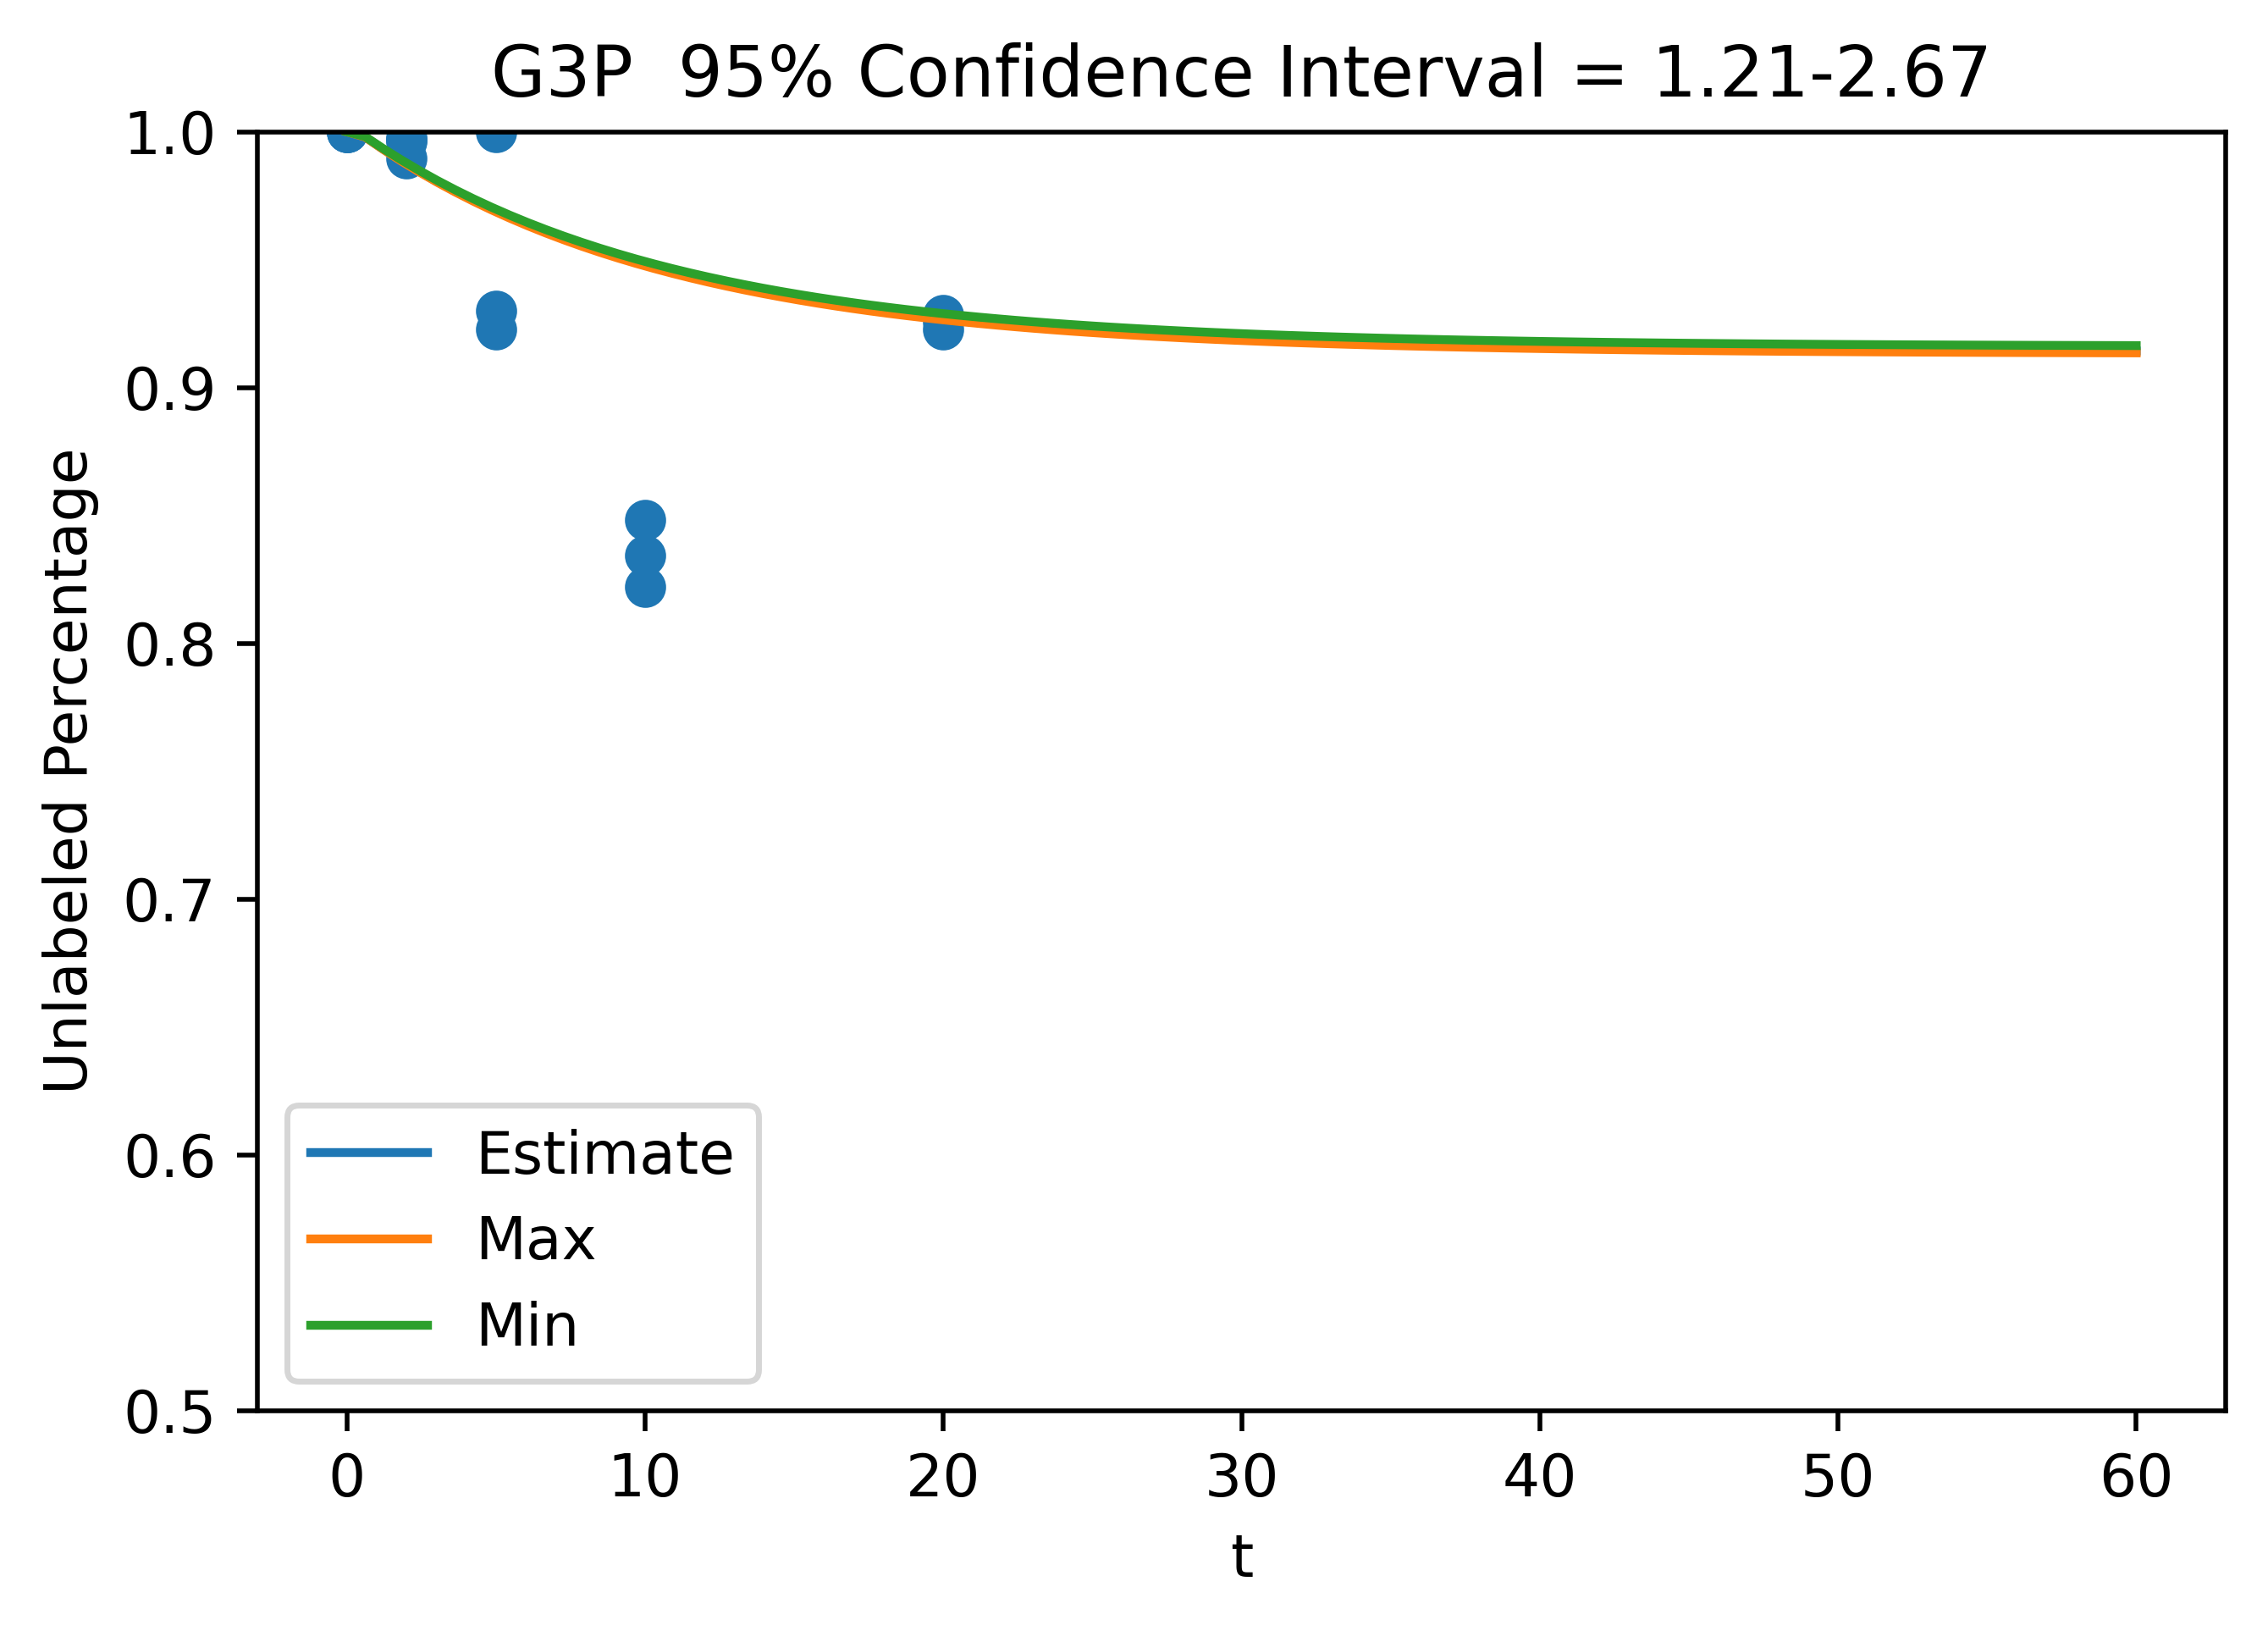

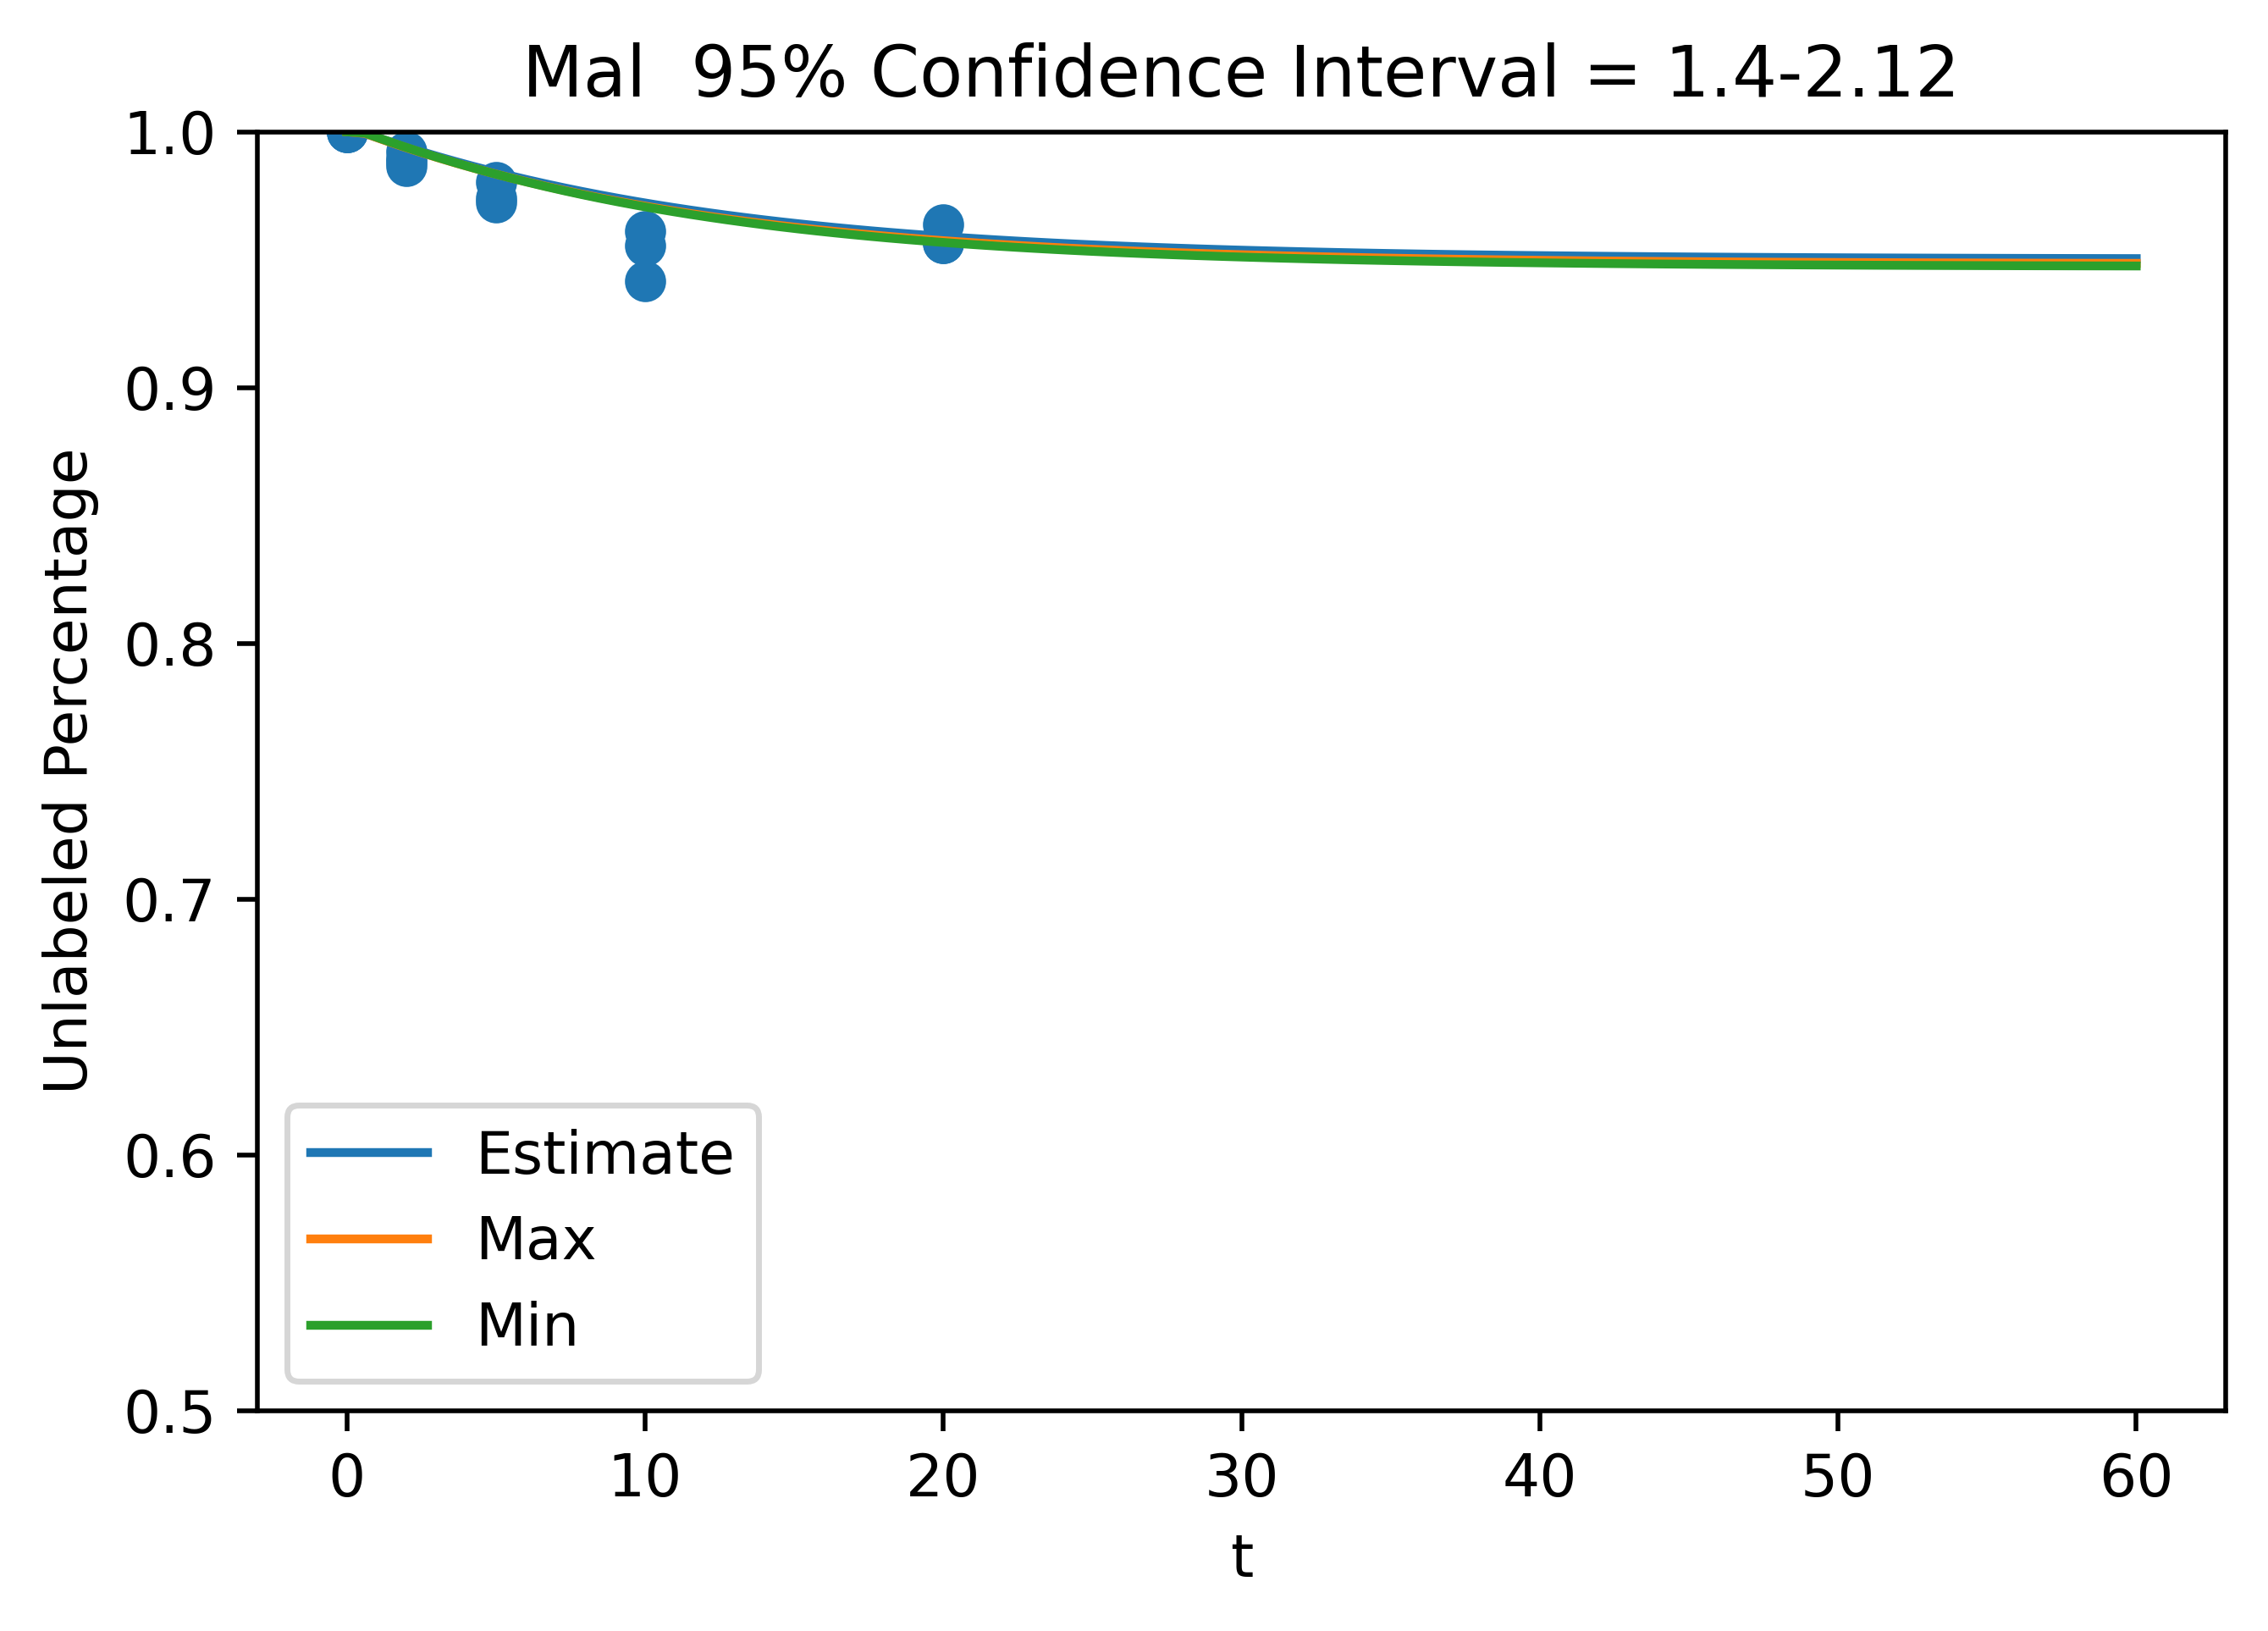

In [32]:
names = ["Lac","G3P","Mal"]


plt.scatter(t,data["UL_nadh"])
plt.plot(t_t,predictedL[:,3])
plt.title("NADH")



plt.figure()
plt.plot(t_t,exponetialCurve(t_t,dhap_params))
plt.title("Ga3P")
plt.scatter(t,data["UL_gap"])

pos = 0
for x,label in zip([0,1,2],["UL_lac","UL_g3p","UL_malate"]):
  print(interval[x])
  fig = plt.figure()
  predictedMaxL = integrateLabelingModel(t_t,intervalParams[x][1][0],conc,dhap_params,intervalParams[x][1][1],vhvds,initialState)
  predictedMinL = integrateLabelingModel(t_t,intervalParams[x][0][0],conc,dhap_params,intervalParams[x][0][1],vhvds,initialState)
  #predictedMaxL = integrateLabelingModel(t_t,intervalParams[x][1][:3],np.append(conc[:-1],intervalParams[x][1][5:6]),intervalParams[x][1][6:-1],intervalParams[x][1][3:5])
  #predictedMinL = integrateLabelingModel(t_t,intervalParams[x][0][:3],np.append(conc[:-1],intervalParams[x][0][5:6]),intervalParams[x][0][6:-1],intervalParams[x][0][3:5])
  plt.scatter(t,data[label])
  plt.plot(t_t,predictedL[:,pos],label="Estimate")
  plt.plot(t_t,predictedMaxL[:,pos],label="Max")
  plt.plot(t_t,predictedMinL[:,pos],label="Min")
  plt.legend()

  plt.xlabel("t")
  plt.ylabel("Unlabeled Percentage")
  plt.title(names[pos] + "  95% Confidence Interval = " + str(np.round(interval[x][0],2))+ "-" + str(np.round(interval[x][1],2)))

  plt.ylim((.5,1.0))
  pos += 1
    
plt.show()



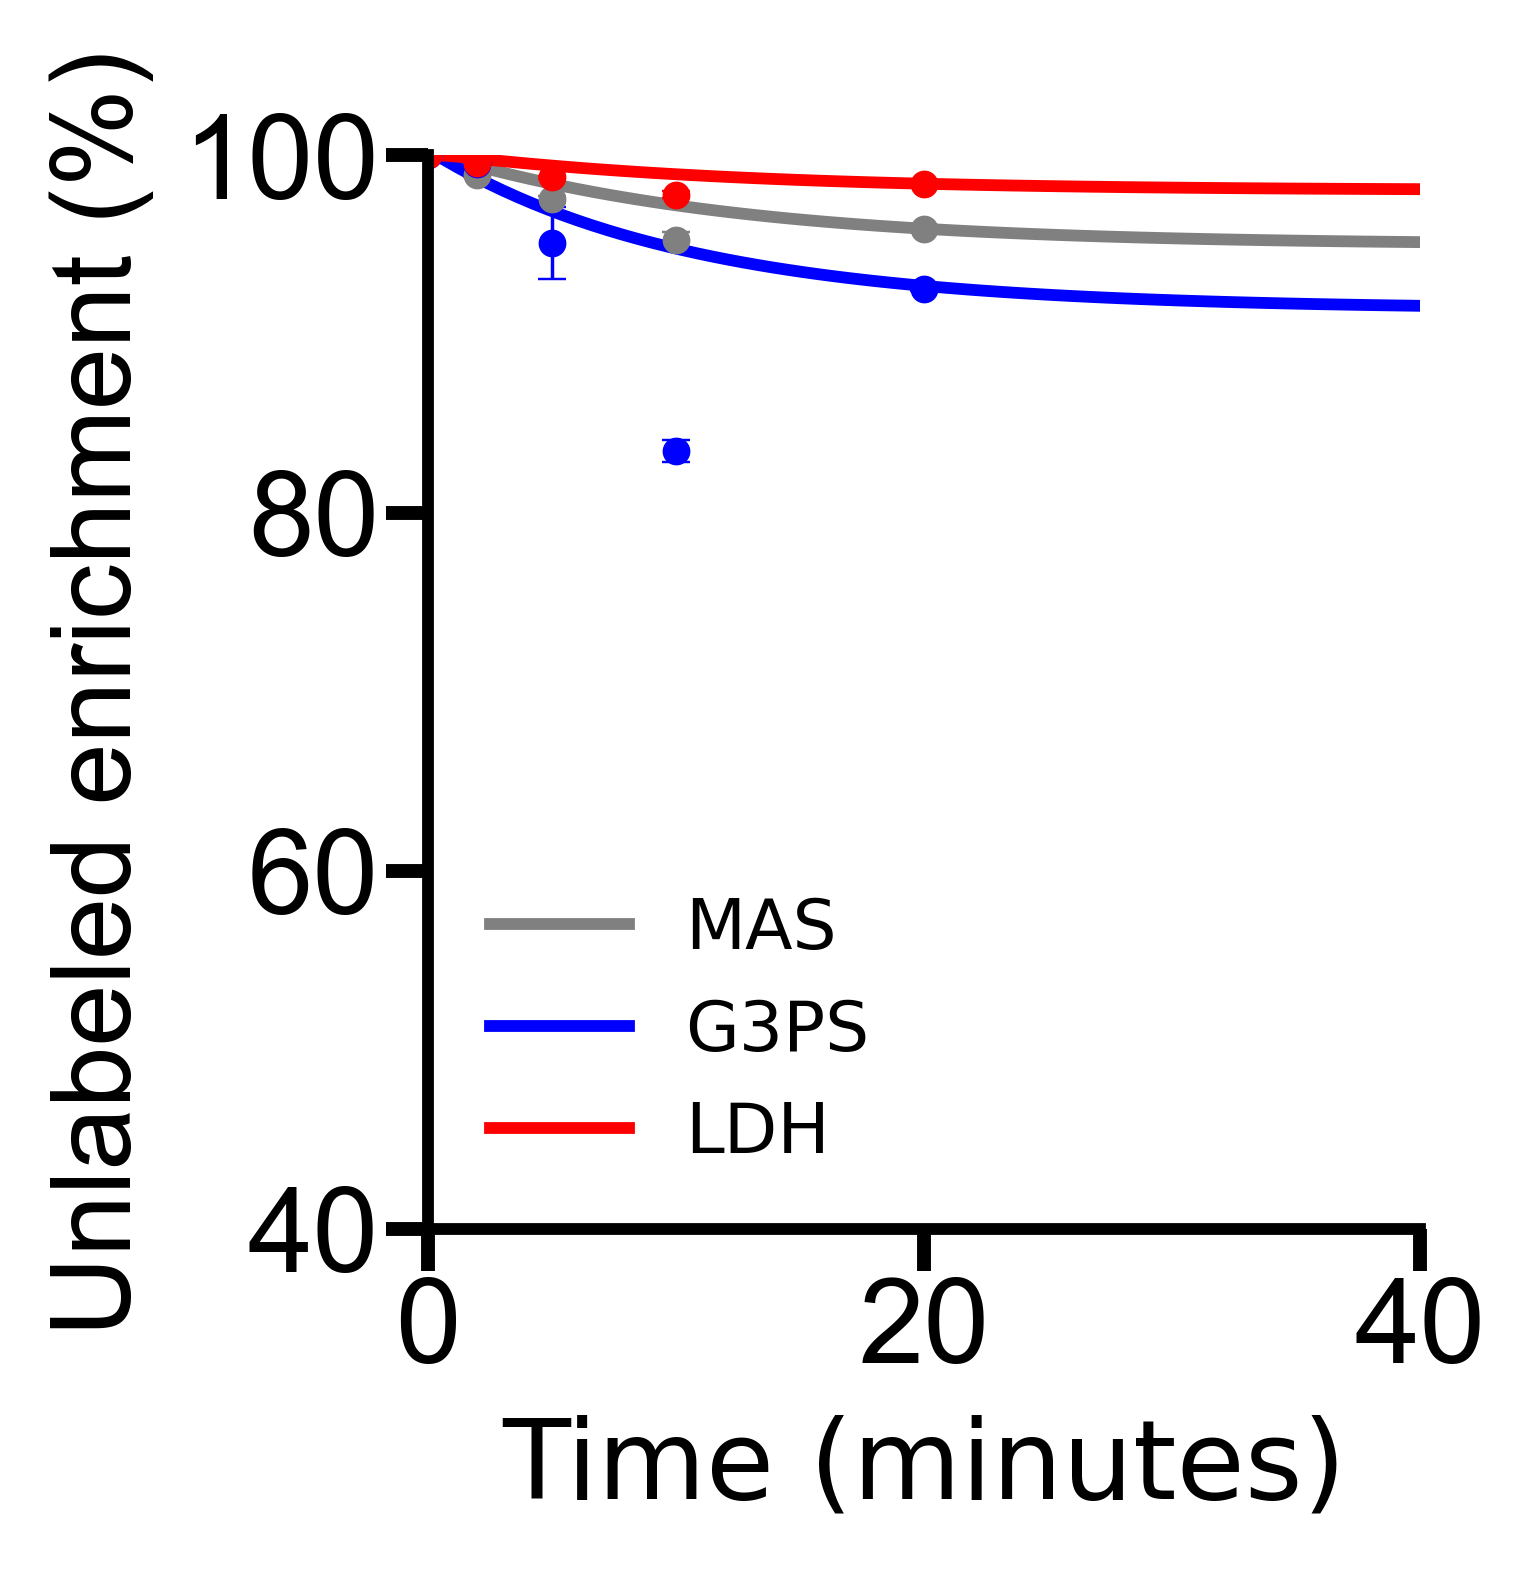

In [33]:
names = ["MAS","G3PS","LDH"]
plt.rcParams["font.weight"] = 500
plt.rcParams["axes.labelweight"] = 500
uniqueTs = list(set(t))
uniqueTs.sort()
#pp = PdfPages(cellType + '.pdf')
limits = [(40,100),(40,100),(40,100)]
colors = ["Grey","Blue","Red"]
fig,ax = plt.subplots(figsize=(3,3))
pos = 0
for x,label,color in zip([2,1,0],["UL_malate","UL_g3p","UL_lac"],colors):
  data2Plot = {tt:[] for tt in uniqueTs}
  tmp = pd.DataFrame(data)
  tmp["t"] = t
  for tt in uniqueTs:
        filt = tmp[tmp["t"] == tt]
        data2Plot[tt] = filt[label].values
        
  #for tt,ll in zip(t,p[:,x+1]):
  #      data2Plot[tt].append(ll)
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt])/np.sqrt(len(data2Plot[tt])) for tt in uniqueTs] 
  
  #print(intervalParams[x])
  #integrateLabelingModel(t_t,intervalParams[x][0][:3],conc,intervalParams[x][0][6:],intervalParams[x][0][3:6])
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color=color,capthick=.35,markersize=3,elinewidth=0.5)
  plt.plot(t_t,[100*i for i in predictedL[:,x]],label=names[pos],color=color,linewidth=1.7)
 
  #plt.xlabel("Time (minutes)",fontname="Arial",fontsize=16,color='black')
  plt.xlabel("Time (minutes)",fontsize=16,color='black')
  plt.ylabel("Unlabeled enrichment (%)",fontsize = 16,fontname = "Arial",color='black')
  #plt.title(names[x+1] + " Flux = " + str(np.round(bestParams[x],2)) + " 95% CI = [" + str(np.round(interval[x][0],2))+ "," + str(np.round(interval[x][1],2)) + "]")
  #plt.title(names[x+1],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
  pos += 1

ax=plt.gca();
ax.spines['bottom'].set_linewidth(1.7);
ax.spines['left'].set_linewidth(1.7);
plt.tick_params(labelsize=17)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

axis = plt.gca().xaxis
#axis.get_ticklabels()  
#axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    
axis = plt.gca().yaxis
#axis.get_ticklabels()  
#axis.get_ticklines()  
for label in axis.get_ticklabels():
    label.set_color('black')          
    label.set_fontsize(17)          
for line in axis.get_ticklines():
    line.set_color('black')
    line.set_markersize(6)         
    line.set_markeredgewidth(2)     
    




right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.legend(frameon=False) 
plt.savefig("../data/" + cellType + "/" + cellType + ".png")
#pp.savefig(fig)
#pp.savefig(fig)






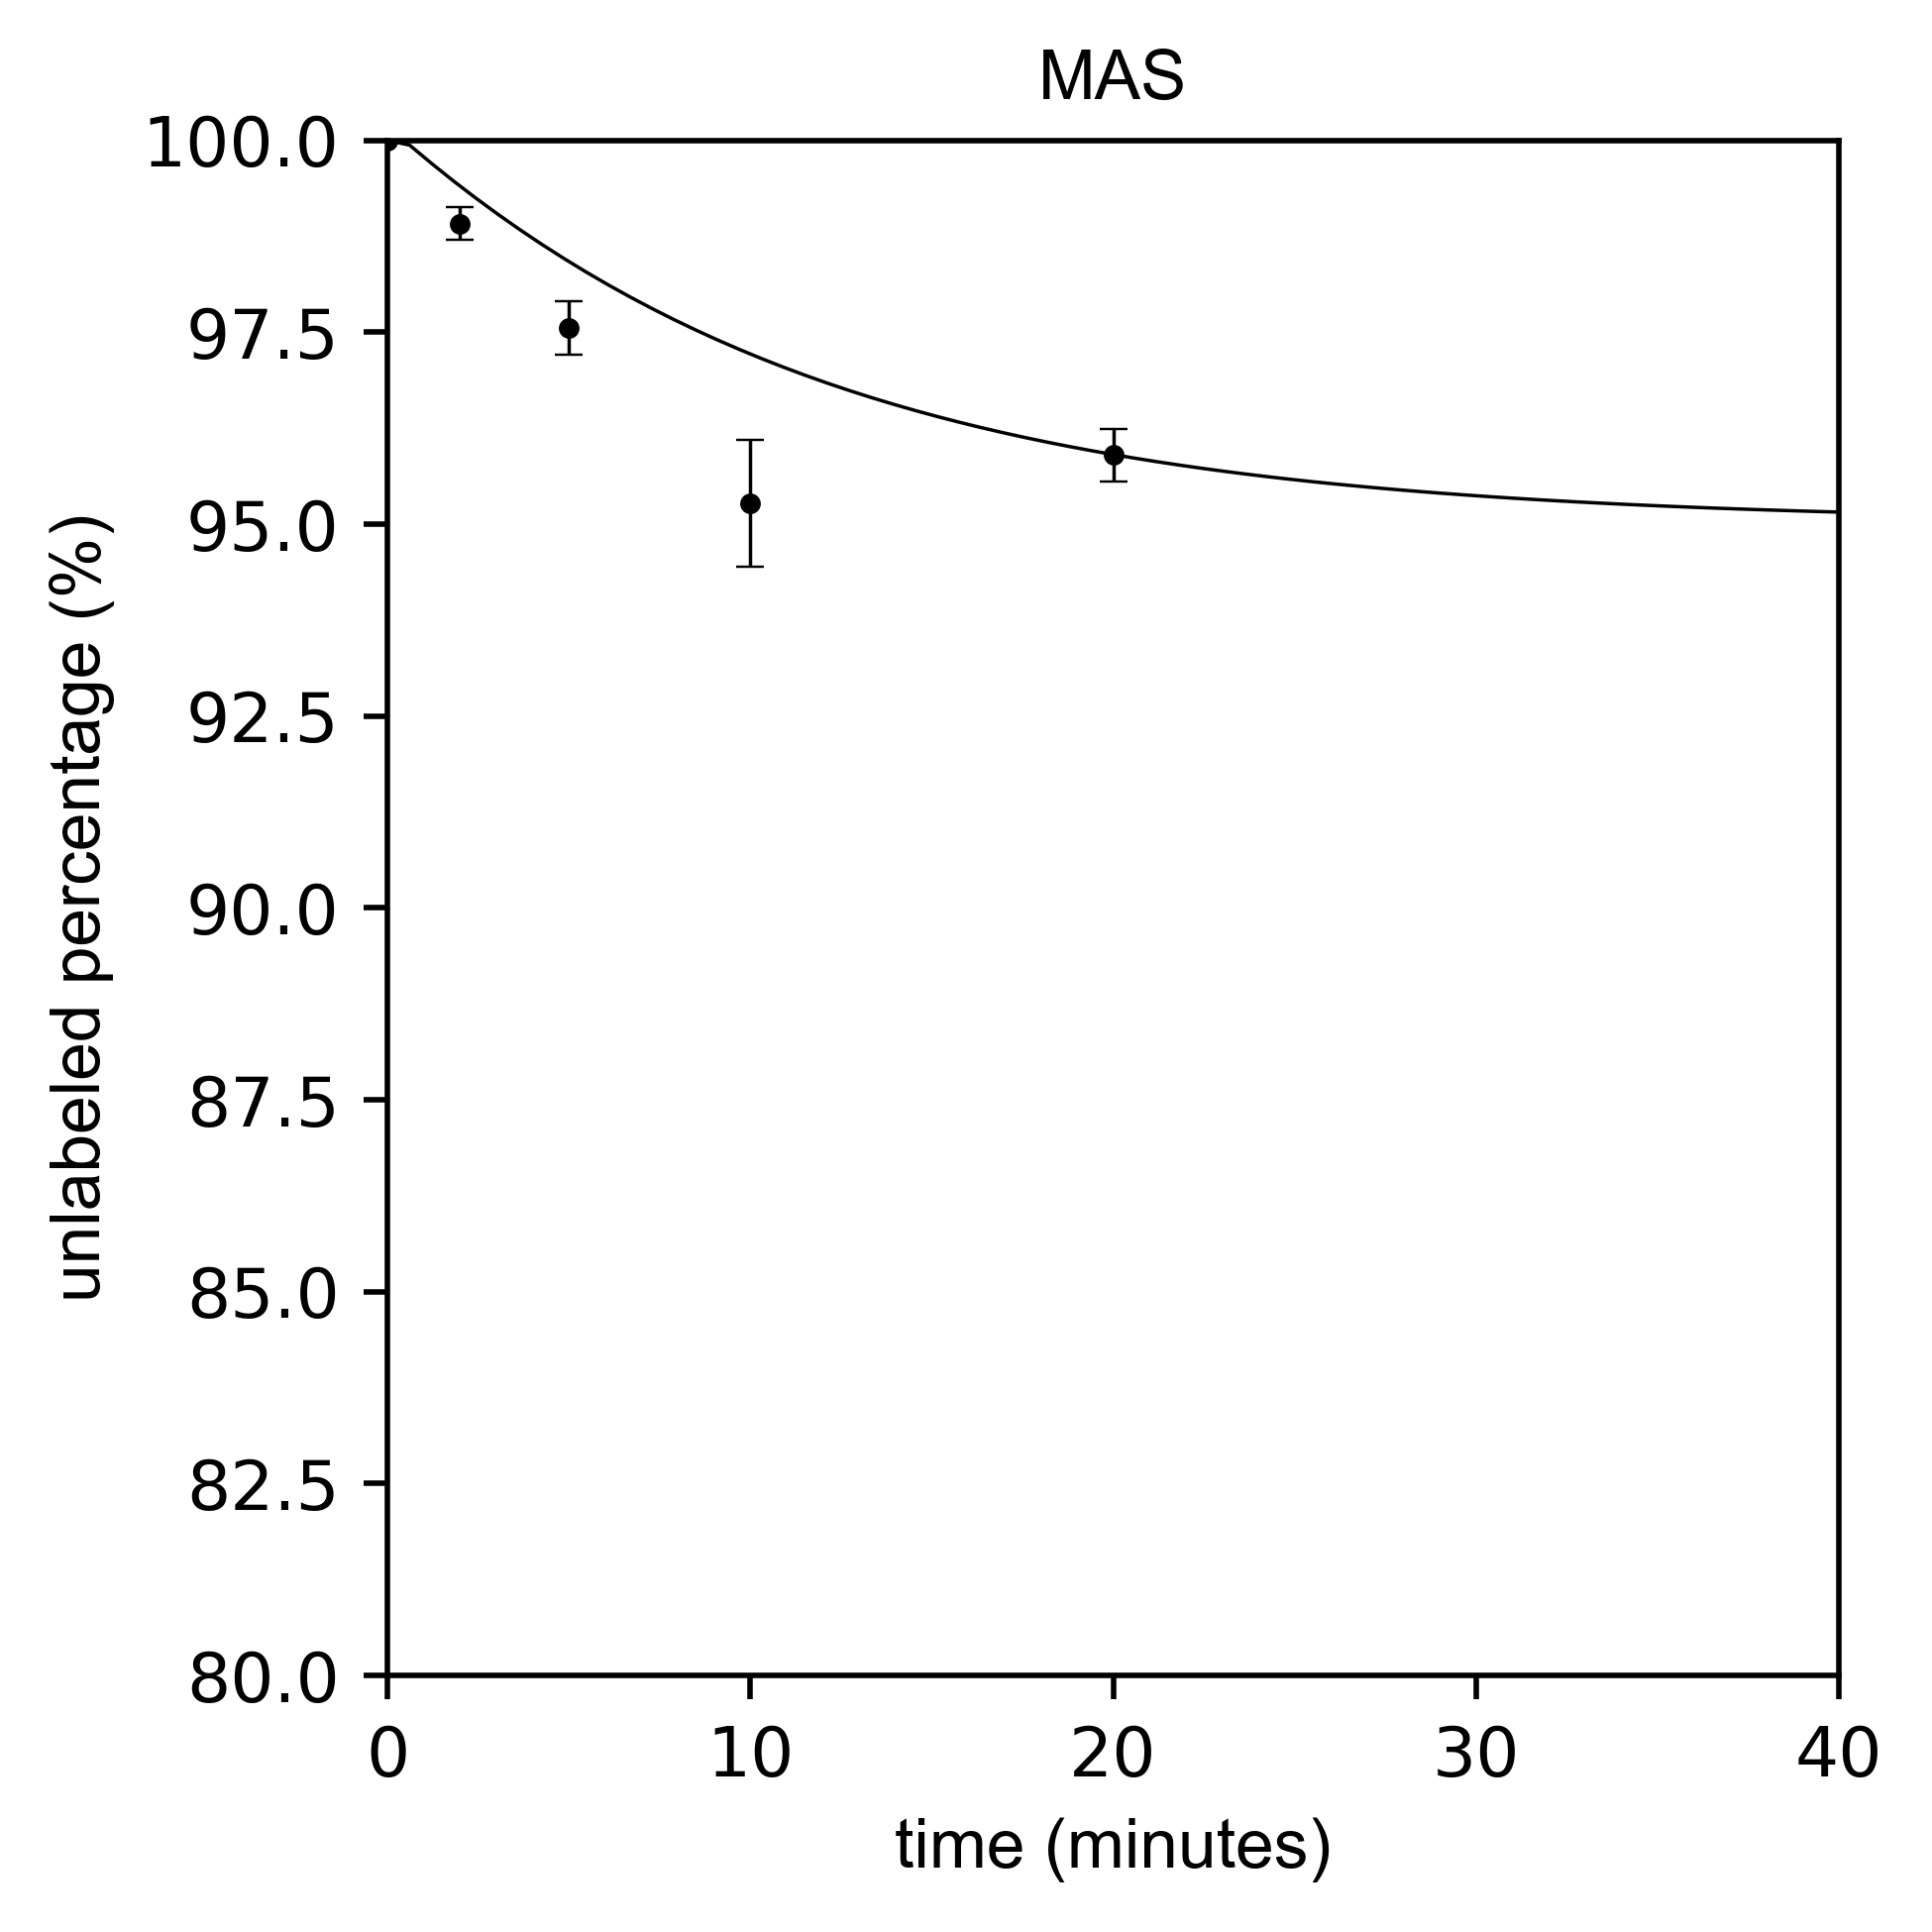

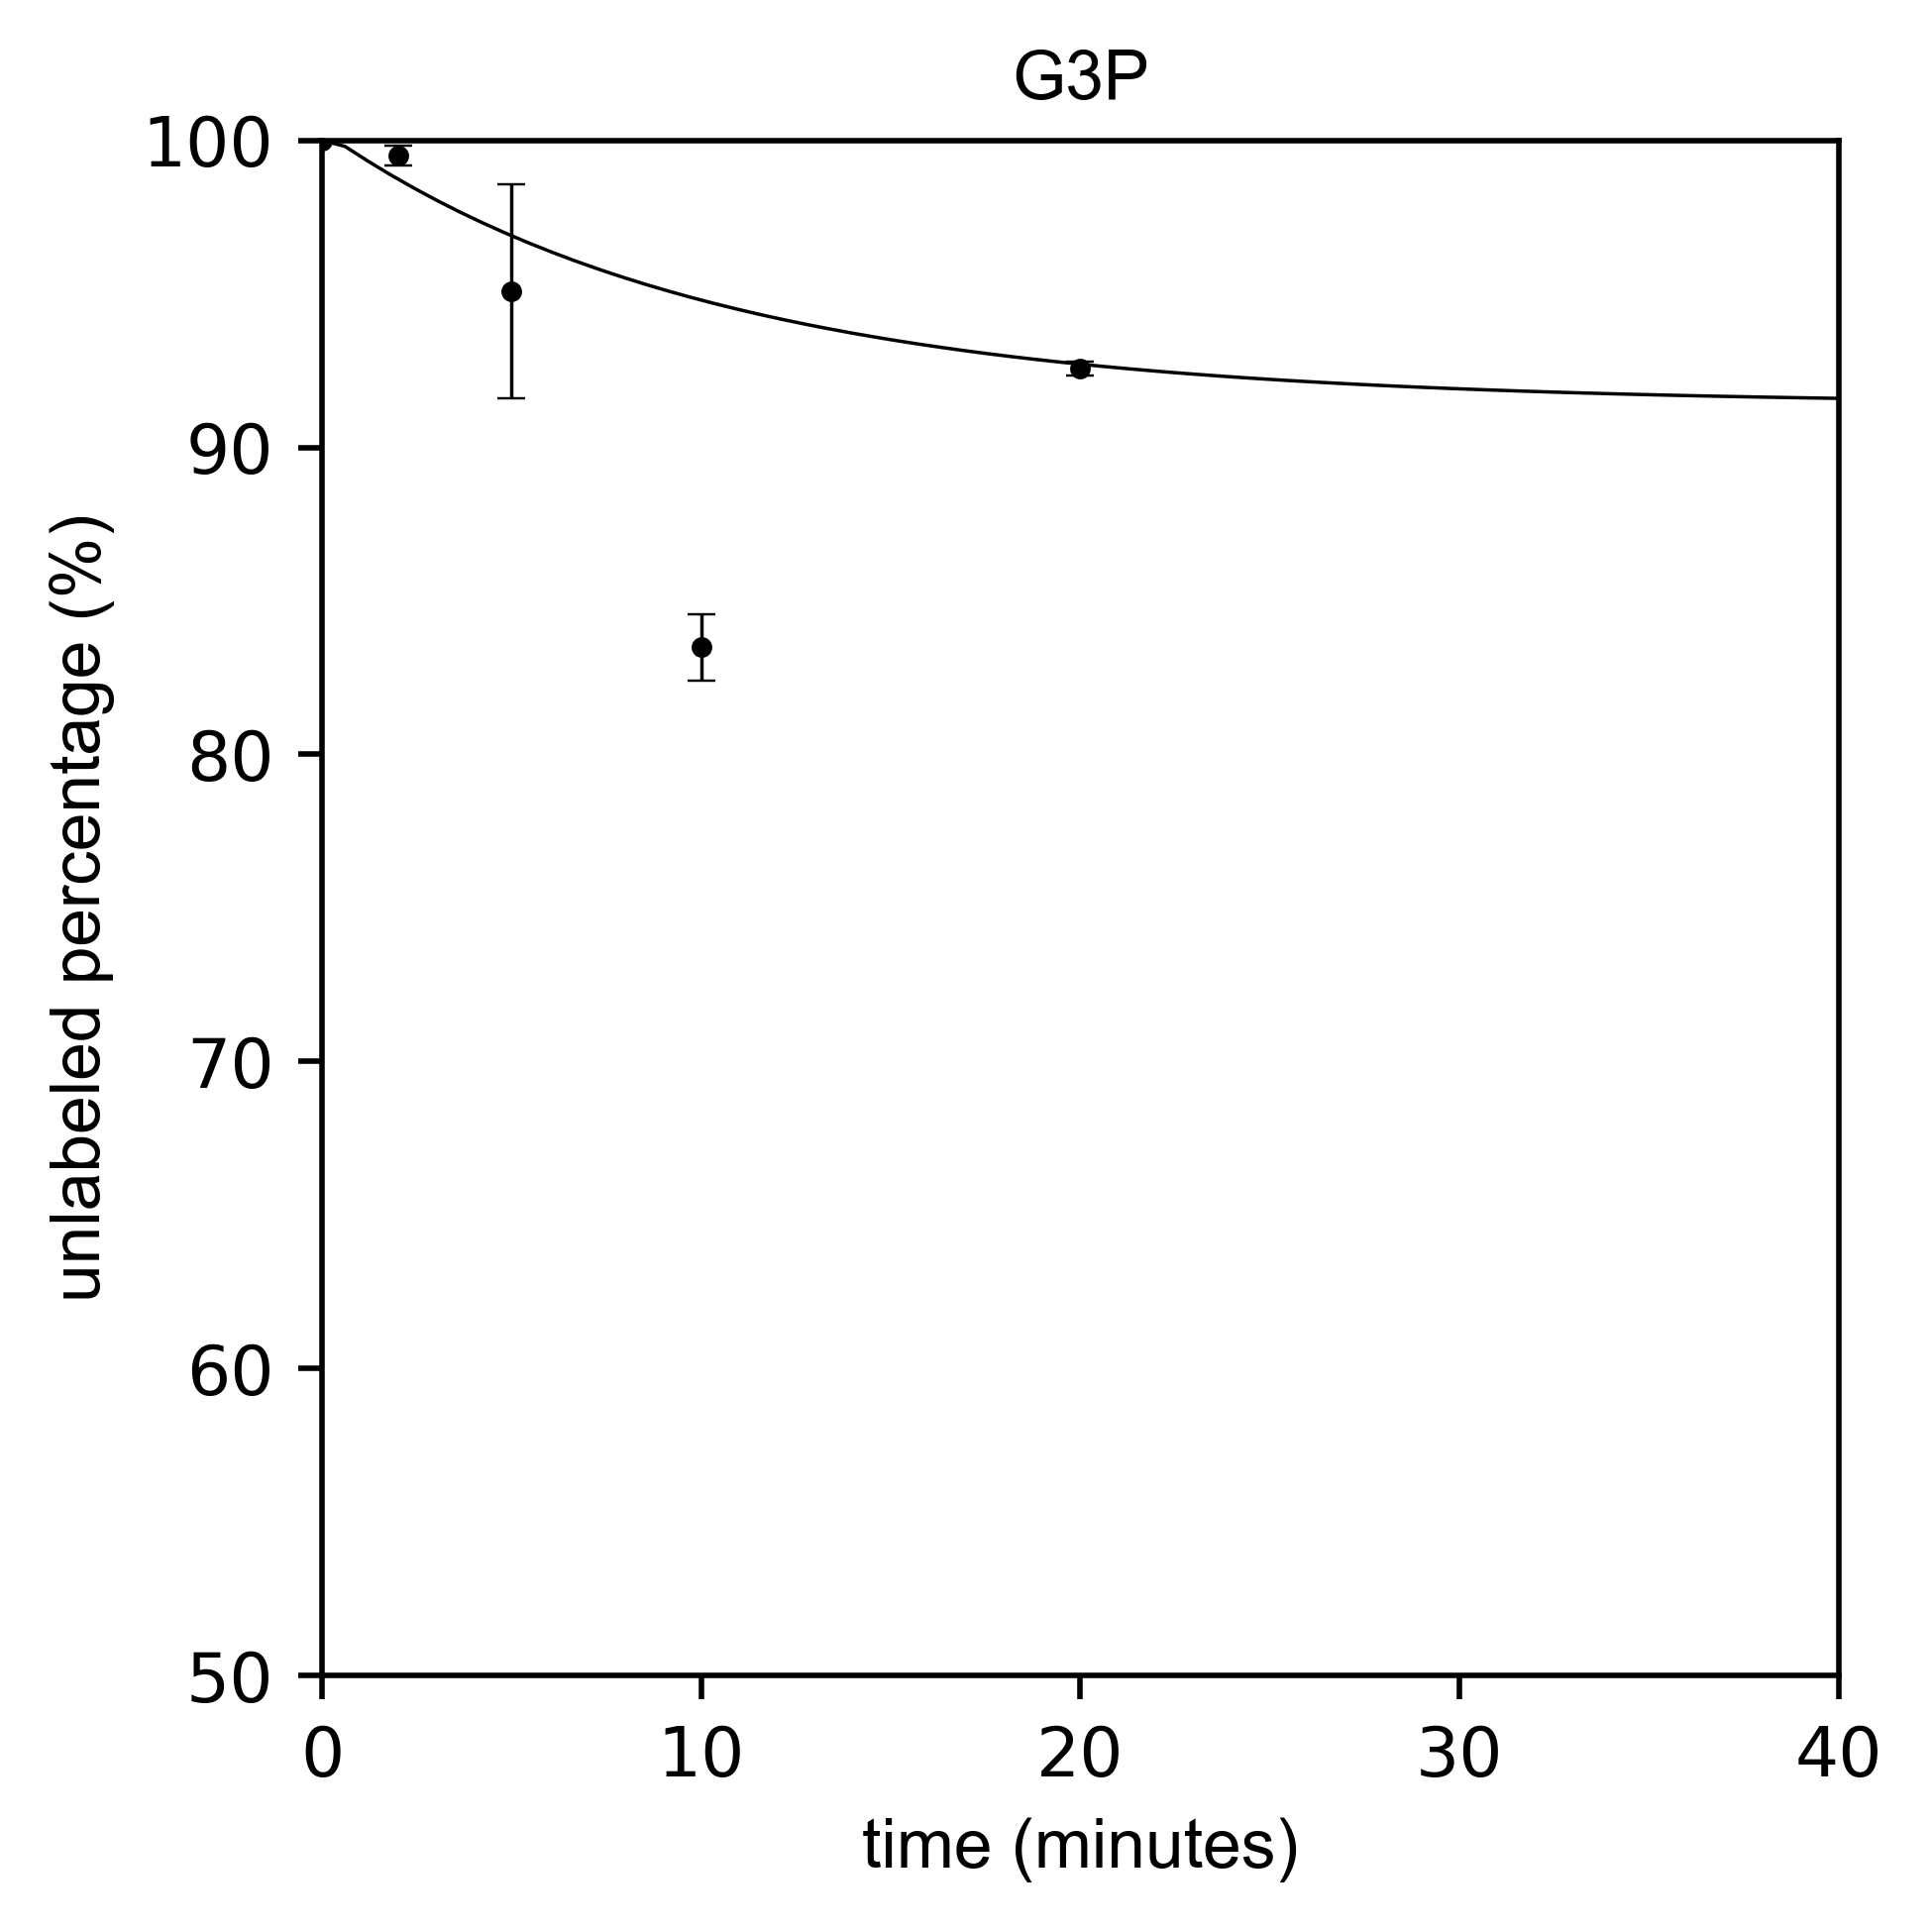

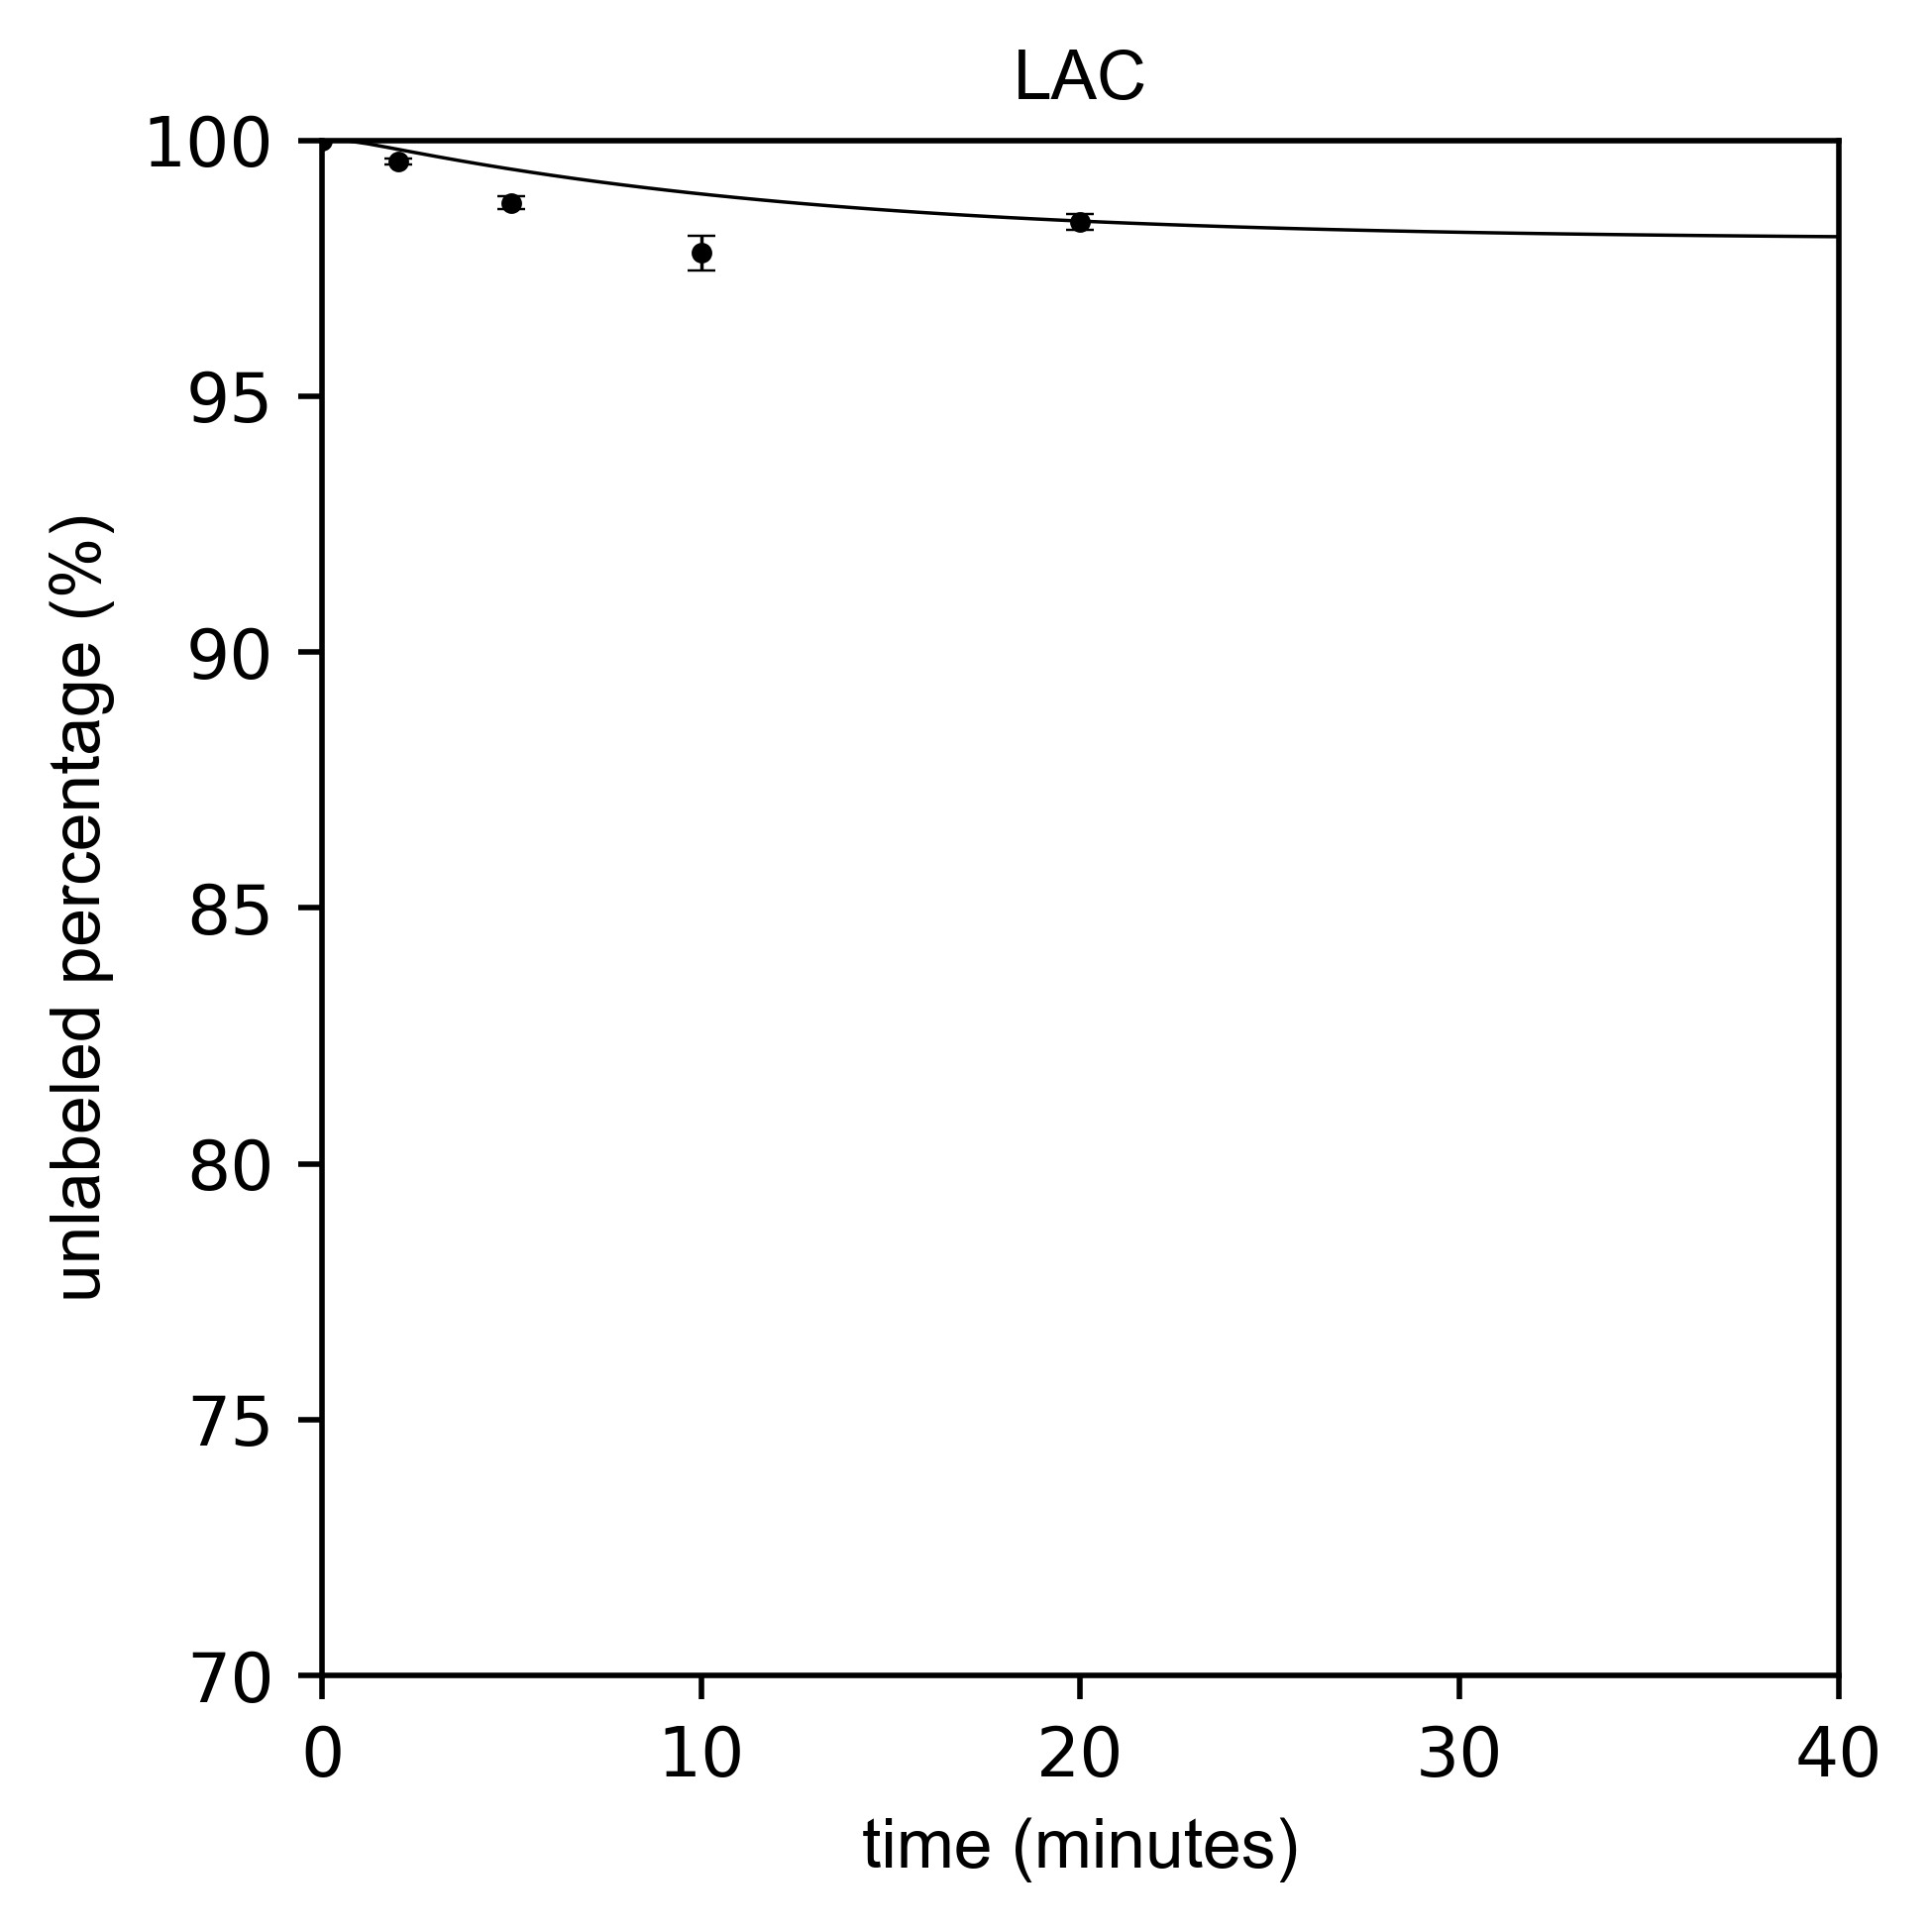

In [34]:
names = ["MAS","G3P","LAC"]


uniqueTs = list(set(t))
uniqueTs.sort()
pp = PdfPages("../data/" + cellType + "/" + cellType + '.pdf')
limits = [(70,100),(50,100),(80,100)]
#colors = ["Grey","dodgerblue","Red"]
pos = 0
for x,label in zip([2,1,0],["UL_malate","UL_g3p","UL_lac"]):
  data2Plot = {tt:[] for tt in uniqueTs}
  tmp = pd.DataFrame(data)
  tmp["t"] = t
  for tt in uniqueTs:
        filt = tmp[tmp["t"] == tt]
        data2Plot[tt] = filt[label].values
  ydata = [100*np.mean(data2Plot[tt]) for tt in uniqueTs]
  yerr = [100*np.std(data2Plot[tt]) for tt in uniqueTs] 
  fig = plt.figure(figsize=(4,4))
  
  plt.errorbar(uniqueTs,ydata,yerr=yerr,fmt="o",capsize=2,color="black",capthick=.35,markersize=2,elinewidth=.50)
  
  plt.plot(t_t,[100*i for i in predictedL[:,x]],label=names[pos],color="black",linewidth=.50)
 
  plt.xlabel("time (minutes)",fontname="Arial",fontsize=10)
  plt.ylabel("unlabeled percentage (%)",fontsize = 10,fontname = "Arial")
  plt.title(names[pos],fontsize=10,fontname = "Arial") 
  plt.xlim((0,40))
  plt.ylim(limits[x])
  fig.tight_layout()
  pp.savefig(fig)
  pos += 1

pp.close()
plt.show()


In [21]:
# delta = .001
# for f,i in zip(bestParams[:-1],range(len(bestParams[:-1]))):
#     x0 = predictedL
#     tempFlux = list(bestParams)
#     tempFlux[i] += delta*tempFlux[i]
#     integrateLabelingModel(t_t,bestParams[:3],np.append(conc[:-1],bestParams[5:6]),bestParams[6:-1],bestParams[3:5])
#     x1 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     tempFlux = list(bestParams)
#     tempFlux[i] -= delta*tempFlux[i]
#     x2 = integrateLabelingModel(t_t,tempFlux[:3],np.append(conc[:-1],tempFlux[5:6]),tempFlux[6:-1],tempFlux[3:5])
#     diff1 = np.abs(np.subtract(x0,x1))
#     diff2 = np.abs(np.subtract(x0,x2))
#     diff = (diff1 + diff2)/2
#     diff = np.sum(diff)/diff.size
#     sensitivity = diff/(delta*tempFlux[i])
#     print(sensitivity)